#Business Problem

<h1> Description </h1>

Source: https://www.kaggle.com/c/favorita-grocery-sales-forecasting 

Data: https://www.kaggle.com/c/favorita-grocery-sales-forecasting/data

Problem Statement: Need to build a model that more accurately forecasts product sales. In this case we are predicting future sales for a grocery store chain called 'Corporacion Favorita'. This is one case of demand forecasting, also, with being such a big grocery store, stock outs and over stocking can be a major concern. So, with this case study we are trying to implement machine learning to predict the unit sales of items sold by Corporacion Favorita.

<h1> Sources Referred:

1. https://pdfs.semanticscholar.org/74b7/dd4a1bb435699c076dbcad9e826107c06c41.pdf 

2. https://arxiv.org/pdf/1803.04037.pdf

3. http://web.stanford.edu/class/archive/cs/cs221/cs221.1192/2018/restricted/posters/jzhao4/poster.pdf 

Business Objectives and Constraints:

1. No low-latency requirement.

2. Errors can be costly, as stock outs or over stocking are not good in terms of business.

3. Interpretability is not important.

#Machine Learning Problem Formulation

<h1> Data </h1>

**Data Overview**

Source: https://www.kaggle.com/c/favorita-grocery-sales-forecasting/data

We are provided with 6 files(excluding test file), we need to make prediction at item-store level.

train.csv:

1. Training data, which includes the target unit_sales by date, store_nbr, and item_nbr and a unique id to label rows.
2. The target unit_sales can be integer (e.g., a bag of chips) or float (e.g., 1.5 kg of cheese).
3. Negative values of unit_sales represent returns of that particular item.
4. The onpromotion column tells whether that item_nbr was on promotion for a specified date and store_nbr.
5. Approximately 16% of the onpromotion values in this file are NaN.
6. NOTE: The training data does not include rows for items that had zero unit_sales for a store/date combination. There is no information as to whether or not the item was in stock for the store on the date. Also, there are a small number of items seen in the training data that aren't seen in the test data.

stores.csv:
1. Store metadata, including city, state, type, and cluster.
2. cluster is a grouping of similar stores.

items.csv:
1. Item metadata, including family, class, and perishable.
2. NOTE: Items marked as perishable have a score weight of 1.25; otherwise, the weight is 1.0.

transactions.csv:
1. The count of sales transactions for each date, store_nbr combination. Only included for the training data timeframe.

oil.csv:
1. Daily oil price. Includes values during both the train and test data timeframe. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

holidays_events.csv:
1. Holidays and Events, with metadata
2. NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
3. Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).


<h1> Type of Machine Learning Problem </h1>
We are here trying to forecast unit sales of item per store, i.e, we are looking at a time series data at an item-store level.

<h1> Performance Metric </h1>

Source: https://www.kaggle.com/c/favorita-grocery-sales-forecasting/overview/evaluation

Normalized Weighted Root Mean Squared Logarithmic Error (NWRMSLE), calculated as follows:

$$ NWRMSLE = \sqrt{ \frac{\sum{i=1}^n wi \left( \ln(\hat{y}i + 1) - \ln(yi +1)  \right)^2  }{\sum{i=1}^n wi}} $$

where for row i, \(\hat{y}i\) is the predicted unitsales of an item and \(yi\) is the actual unitsales; n is the total number of rows in the test set.

#Getting Enviornment Set

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist//spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar -xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'/content/spark-2.4.5-bin-hadoop2.7'

<h1> Major imports </h1>

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType, IntegerType, StringType, FloatType
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<h1> Starting spark session </h1>

In [0]:
conf = pyspark.SparkConf().setAppName('CaseStudy1').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

#EXPLORATORY DATA ANALYSIS

We are provided with multiple files, let's just read them all in one go, we will see what we have in each of these files and will go about them one by one.

In [0]:
train_df = spark.read.format("csv").option("header", "true").load('/content/drive/My Drive/Grocery/train.csv')
test_df = spark.read.format("csv").option("header", "true").load('/content/drive/My Drive/Grocery/test.csv')
transactions_df = spark.read.format("csv").option("header", "true").load('/content/drive/My Drive/Grocery/transactions.csv')
stores_df = spark.read.format("csv").option("header", "true").load('/content/drive/My Drive/Grocery/stores.csv')
oil_df = spark.read.format("csv").option("header", "true").load('/content/drive/My Drive/Grocery/oil.csv')
items_df = spark.read.format("csv").option("header", "true").load('/content/drive/My Drive/Grocery/items.csv')
holidays_events_df = spark.read.format("csv").option("header", "true").load('/content/drive/My Drive/Grocery/holidays_events.csv')

<h1> train data </h1>

If we try to print top rows this is what we get

In [17]:
train_df.show()

+---+----------+---------+--------+----------+-----------+
| id|      date|store_nbr|item_nbr|unit_sales|onpromotion|
+---+----------+---------+--------+----------+-----------+
|  0|2013-01-01|       25|  103665|       7.0|       null|
|  1|2013-01-01|       25|  105574|       1.0|       null|
|  2|2013-01-01|       25|  105575|       2.0|       null|
|  3|2013-01-01|       25|  108079|       1.0|       null|
|  4|2013-01-01|       25|  108701|       1.0|       null|
|  5|2013-01-01|       25|  108786|       3.0|       null|
|  6|2013-01-01|       25|  108797|       1.0|       null|
|  7|2013-01-01|       25|  108952|       1.0|       null|
|  8|2013-01-01|       25|  111397|      13.0|       null|
|  9|2013-01-01|       25|  114790|       3.0|       null|
| 10|2013-01-01|       25|  114800|       1.0|       null|
| 11|2013-01-01|       25|  115267|       1.0|       null|
| 12|2013-01-01|       25|  115611|       1.0|       null|
| 13|2013-01-01|       25|  115693|       1.0|       nul

**Let us first see what info is already provided to us, the important one:**
>>Negative values of unit_sales represent returns of that particular item

>> Approximately 16% of the onpromotion values in this file are NaN.

>> The training data does not include rows for items that had zero unit_sales for a store/date combination. There is no information as to whether or not the item was in stock for the store on the date, and we need to decide the best way to handle that situation. Also, there are a small number of items seen in the training data that aren't seen in the test data.

In [18]:
train_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- store_nbr: string (nullable = true)
 |-- item_nbr: string (nullable = true)
 |-- unit_sales: string (nullable = true)
 |-- onpromotion: string (nullable = true)



As we can see all the dtypes for all the columns are string, let us just convert them as to what they actually be

In [0]:
train_df = train_df.withColumn('id', col('id').cast(IntegerType())).withColumn('date', col('date').cast(DateType())).withColumn('store_nbr', col('store_nbr').cast(IntegerType())).withColumn('item_nbr', col('item_nbr').cast(IntegerType())).withColumn('unit_sales', col('unit_sales').cast(FloatType())).withColumn('onpromotion', col('onpromotion').cast(StringType()))

In [20]:
train_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- store_nbr: integer (nullable = true)
 |-- item_nbr: integer (nullable = true)
 |-- unit_sales: float (nullable = true)
 |-- onpromotion: string (nullable = true)



In [21]:
print('Total number of rows in train: {}'.format(train_df.count()))

Total number of rows in train: 125497040


In [22]:
#Creating a table view so that we can use SQL queries to collect data and shows results....
train_df.createOrReplaceTempView('data')
train_df.cache

<bound method DataFrame.cache of DataFrame[id: int, date: date, store_nbr: int, item_nbr: int, unit_sales: float, onpromotion: string]>

**Let us see how many null values we have for onpromotion data**

In [23]:
spark.sql('select onpromotion, count(1) as counts from data group by onpromotion').show()

+-----------+--------+
|onpromotion|  counts|
+-----------+--------+
|      False|96028767|
|       null|21657651|
|       True| 7810622|
+-----------+--------+



In [0]:
#Digging deep into it
spark.sql('select EXTRACT(YEAR FROM date) as year, onpromotion, count(1) from data group by year, onpromotion order by year ').show()

+----+-----------+--------+
|year|onpromotion|count(1)|
+----+-----------+--------+
|2013|       null|16322662|
|2014|       True|  459114|
|2014|      False|16477499|
|2014|       null| 5334989|
|2015|      False|26777369|
|2015|       True| 1087275|
|2016|      False|31715287|
|2016|       True| 3514584|
|2017|       True| 2749649|
|2017|      False|21058612|
+----+-----------+--------+



We can see that the null values are for year 2013 and 2014, from 2015 we don't see any null values for onpromotion, so it looks like promotions were not tracked for these parts with missing values for on promotion. Atleast, we know about the missing part(null values) of the data, which is good....

**Let us start by plotting frequencies of data point on yearly/monthly/daily basis**

In [0]:
year_data = spark.sql('select EXTRACT(YEAR FROM date) as year, count(1) as counts from data group by year order by year').toPandas()

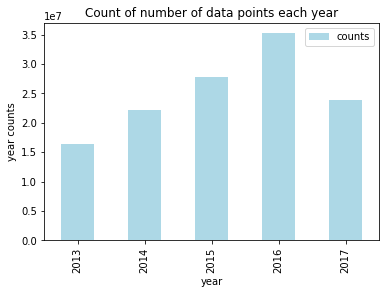

In [0]:
x_labels = year_data['year'].values
fig = year_data[['counts']].plot(kind='bar', facecolor='lightblue')
fig.set_xticklabels(x_labels)
fig.set_title('Count of number of data points each year')
fig.set_xlabel('year')
fig.set_ylabel('year counts')
plt.show()


This shows an increasing trend in terms of dates, which indicates rising sales and/or rise in the units sold year by year, for 2017 we have data only till 2017, but in general an upward trend

In [0]:
monthly_data = spark.sql('select EXTRACT(MONTH FROM date) as year, count(1) as counts from data group by year order by year').toPandas()

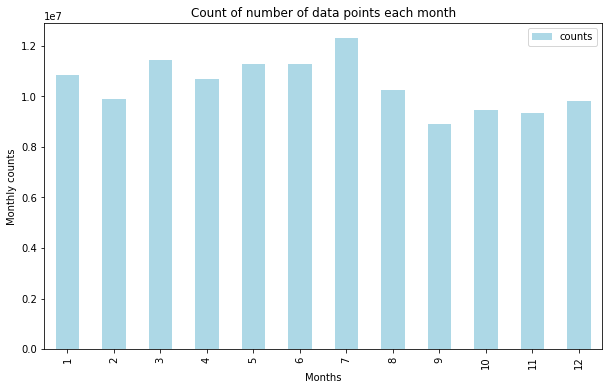

In [0]:
x_labels = monthly_data['year'].values
fig = monthly_data[['counts']].plot(kind='bar', facecolor='lightblue', figsize=(10, 6))
fig.set_xticklabels(x_labels)
fig.set_title('Count of number of data points each month')
fig.set_xlabel('Months')
fig.set_ylabel('Monthly counts')
plt.show()


There is not much to tell from this plot, uniformity is what it shows....

In [0]:
daily_data = spark.sql('select EXTRACT(DAY FROM date) as year, count(1) as counts from data group by year order by year').toPandas()

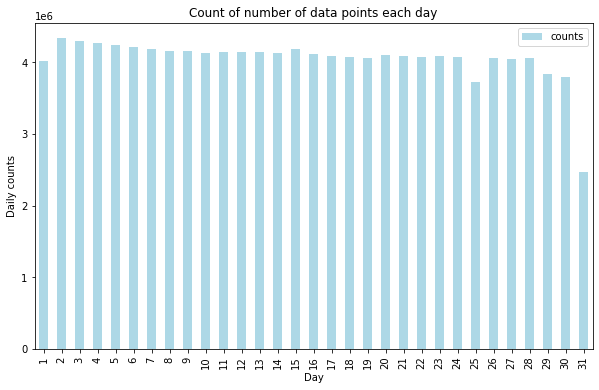

In [0]:
x_labels = daily_data['year'].values
fig = daily_data[['counts']].plot(kind='bar', facecolor='lightblue', figsize=(10, 6))
fig.set_xticklabels(x_labels)
fig.set_title('Count of number of data points each day')
fig.set_xlabel('Day')
fig.set_ylabel('Daily counts')
plt.show()


Uniformly distributed among days, for 31st we see less observation, but then not all month have 31 days.....

In [0]:
#Counting the total number of items
spark.sql('select COUNT(DISTINCT item_nbr) FROM data').show()

+------------------------+
|count(DISTINCT item_nbr)|
+------------------------+
|                    4036|
+------------------------+



We have a universe of 4036 items

In [0]:
#Total stores
spark.sql('select COUNT(DISTINCT store_nbr) FROM data').show()

+-------------------------+
|count(DISTINCT store_nbr)|
+-------------------------+
|                       54|
+-------------------------+



Total number of stores selling these items are : 54

In [0]:
spark.sql('select EXTRACT(YEAR FROM date) as year, COUNT(DISTINCT item_nbr) as items FROM data  GROUP BY year ORDER BY year').show()

+----+-----+
|year|items|
+----+-----+
|2013| 1977|
|2014| 2885|
|2015| 3445|
|2016| 3886|
|2017| 4018|
+----+-----+



Total number of items in universe is: 4036, we can see that number of items they are selling increases with each year, now, for 2017 we have a total of 4018 items and for 2016 we have 3886, there are new items launched in 2017 which may have less data points, also, in test set it is already stated that we have unseen items, we need to deal with such data points during training or modelling. Also, in our data set we may have items that may be discontinued, we need to see if we can somehow figure out those items and remove them from the whole training if required.....

In [0]:
spark.sql('select EXTRACT(YEAR FROM date) as year, COUNT(DISTINCT store_nbr) as items FROM data  GROUP BY year ORDER BY year').show()

+----+-----+
|year|items|
+----+-----+
|2013|   47|
|2014|   48|
|2015|   53|
|2016|   53|
|2017|   54|
+----+-----+



From above we can say that 47 stores were there in 2013, 1 new store opened in 2014, 5 new opened in 2015 and 1 started in 2017

**Total Sales By Store**

In [0]:
store_unit_sales = spark.sql('select store_nbr, SUM(unit_sales) as total_sales FROM data WHERE unit_sales > 0 GROUP BY store_nbr').toPandas()

Text(0, 0.5, 'Total Sales')

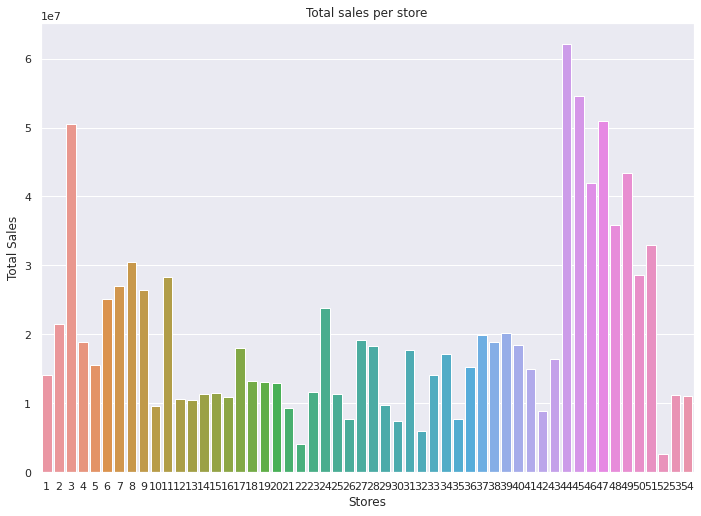

In [0]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(store_unit_sales['store_nbr'].values, store_unit_sales['total_sales'].values)
plt.title('Total sales per store')
plt.xlabel('Stores')
plt.ylabel('Total Sales')

We can say Store number 3,44,45,46,47,48,49 corresponds to high volume of sales 

<h2> Let us try to plot unit sales and see what kind of signal we get </h2>

In [0]:
sales_date_agg = spark.sql('select date, SUM(unit_sales) as total_sales FROM data WHERE unit_sales > 0 GROUP BY date ORDER BY date').toPandas()

Text(0.5, 1.0, 'Plot of total sales over time(daily)')

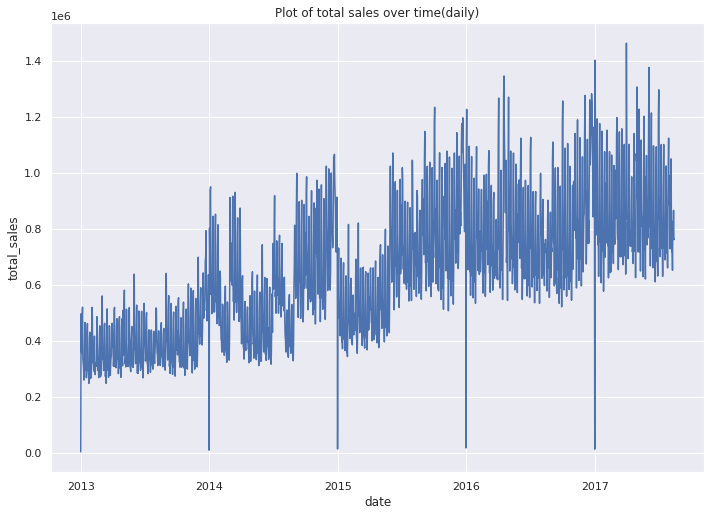

In [0]:
sns.lineplot(x=sales_date_agg['date'], y=sales_date_agg['total_sales'])
plt.title('Plot of total sales over time(daily)')

We can see there is an upward trend, year by year, obviously as the number of items will increase the sales will also increase, let us zoon more into it and plot for one particular year and see how the plot looks like on a daily basis, let us consider plotting this for year 2015 and 2016....

Text(0.5, 1.0, 'Plot of total sales over time(daily) for year 2015')

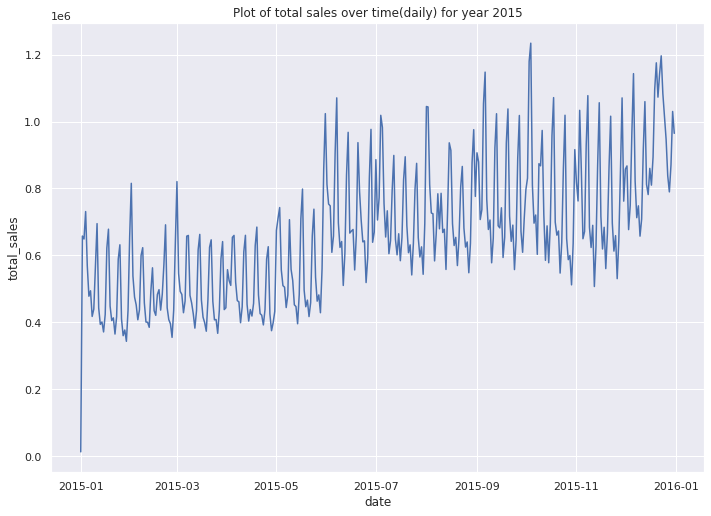

In [0]:
import datetime
start_index = sales_date_agg[sales_date_agg['date'] == datetime.date(2015, 1, 1)].index[0]
end_index = sales_date_agg[sales_date_agg['date'] == datetime.date(2015, 12, 31)].index[0]

year_2015_df = sales_date_agg.loc[start_index : end_index]
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x=year_2015_df['date'], y=year_2015_df['total_sales'])
plt.title('Plot of total sales over time(daily) for year 2015')

A little upward trend with sales for 2015

Text(0.5, 1.0, 'Plot of total sales over time(daily) for year 2016')

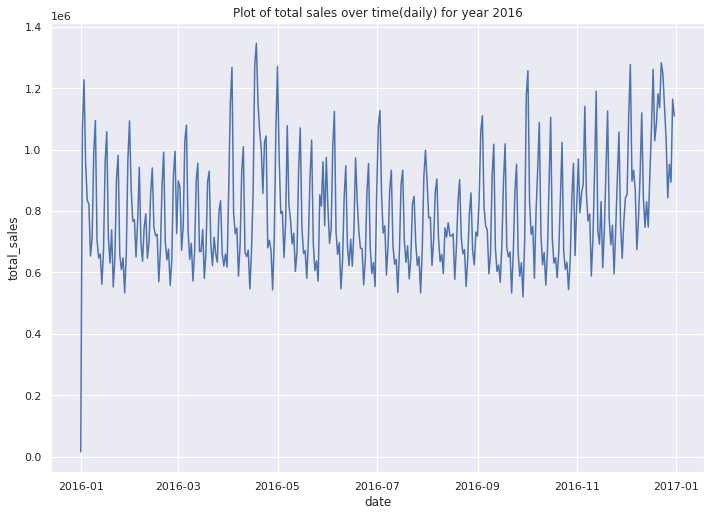

In [0]:
start_index = sales_date_agg[sales_date_agg['date'] == datetime.date(2016, 1, 1)].index[0]
end_index = sales_date_agg[sales_date_agg['date'] == datetime.date(2016, 12, 31)].index[0]

year_2016_df = sales_date_agg.loc[start_index : end_index]
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x=year_2016_df['date'], y=year_2016_df['total_sales'])
plt.title('Plot of total sales over time(daily) for year 2016')

2016 seems to be a stable year in terms of sales, but we need to check more, as selecting right amount of data will be really important to come up with best results....

From the plots seen for 2015 and 2016, we can say that the data in general is uniform in terms of signal that we have if we take total sales in general, this may vary for item as different items will show different signals, as some items may have seasonal affect, some may not.....

**What if we plot total sales on weekly level and monthly level....**

In [0]:
sales_date_agg['week'] = sales_date_agg['date'].apply(lambda x : x.isocalendar()[1])
sales_date_agg['month'] = sales_date_agg['date'].apply(lambda x : x.month)
sales_date_agg['year'] = sales_date_agg['date'].apply(lambda x : x.year)

In [0]:
sales_date_agg.head()

date    total_sales  week  month  year
0  2013-01-01    2511.619000     1      1  2013
1  2013-01-02  496095.418000     1      1  2013
2  2013-01-03  361487.311047     1      1  2013
3  2013-01-04  354472.193056     1      1  2013
4  2013-01-05  477357.121073     1      1  2013

Text(0.5, 1.0, 'Plot of total sales over time(weekly)')

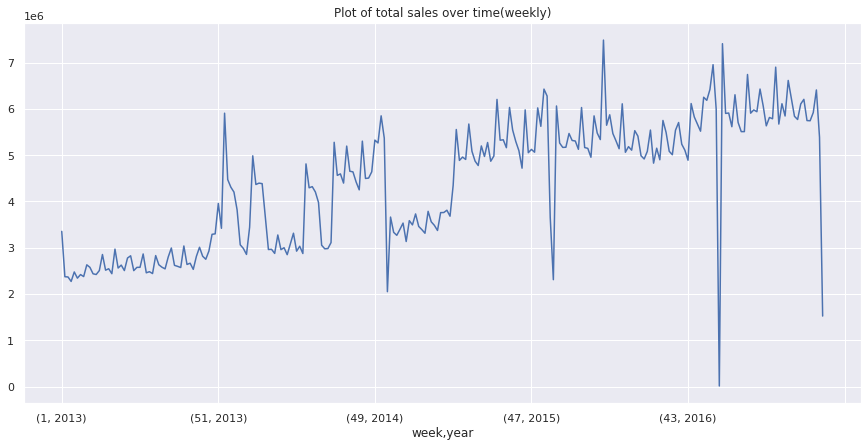

In [0]:
fig, ax = plt.subplots(figsize=(15,7))
sales_date_agg.groupby(['week','year'], sort = False).sum()['total_sales'].plot(ax=ax)
plt.title('Plot of total sales over time(weekly)')

This doesn't add much value to our analysis....

Text(0.5, 1.0, 'Plot of total sales over time(Monthly)')

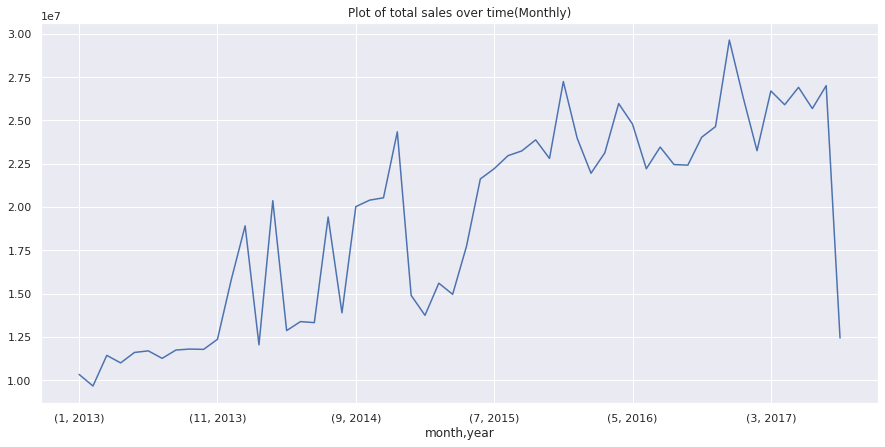

In [0]:
fig, ax = plt.subplots(figsize=(15,7))
sales_date_agg.groupby(['month','year'], sort = False).sum()['total_sales'].plot(ax=ax)
plt.title('Plot of total sales over time(Monthly)')

This doesn't add much value to our analysis....

In [0]:
def plot_line_plot(x, y, txt):
  sns.set(rc={'figure.figsize':(11.7,8.27)})
  sns.lineplot(x =x, y = y)
  plt.title(txt)
  plt.show()

**Let us see Sales of a particular store over time**

In [0]:
date_store_level_data = spark.sql('select date, store_nbr, SUM(unit_sales) as sales_per_store FROM data  GROUP BY date, store_nbr ORDER BY date').toPandas()

In [0]:
date_store_level_data.head()

date  store_nbr  sales_per_store
0  2013-01-01         25      2511.619000
1  2013-01-02         28      5176.473998
2  2013-01-02          9     15867.484008
3  2013-01-02         25      5316.224002
4  2013-01-02         38      9198.507002

In [0]:
store_list = list(date_store_level_data['store_nbr'].unique())

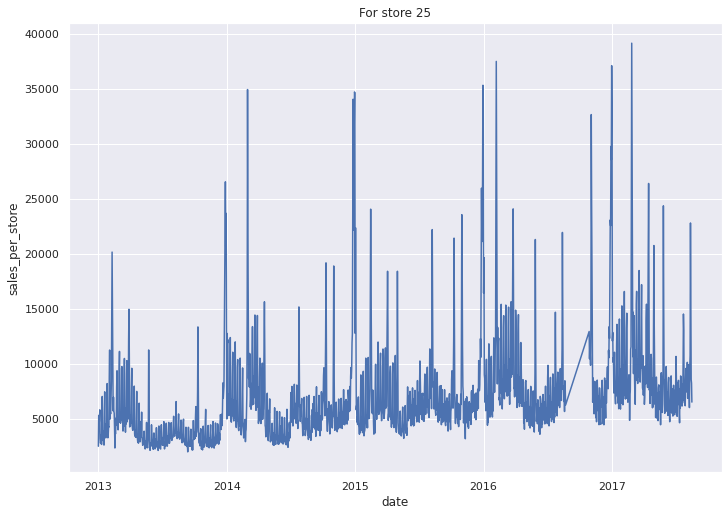

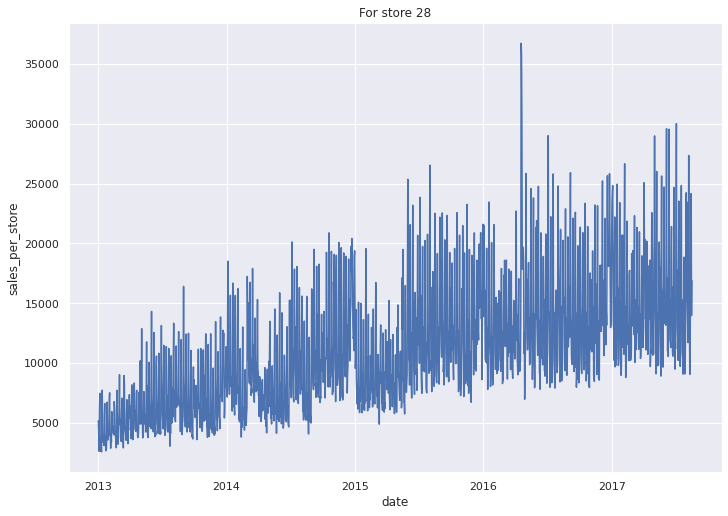

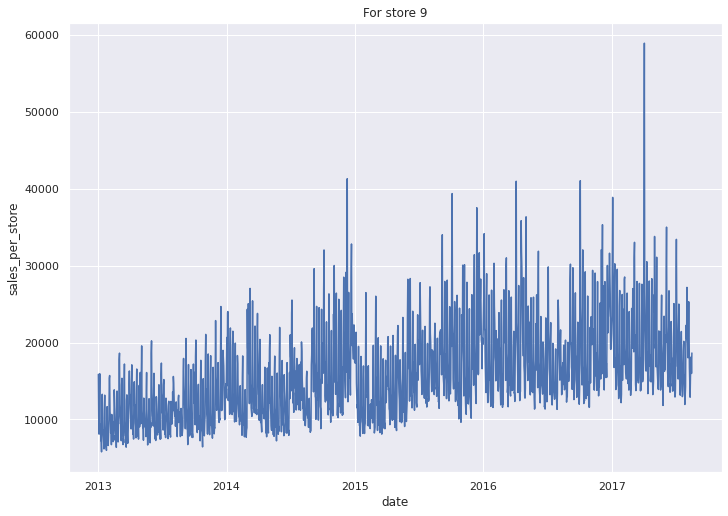

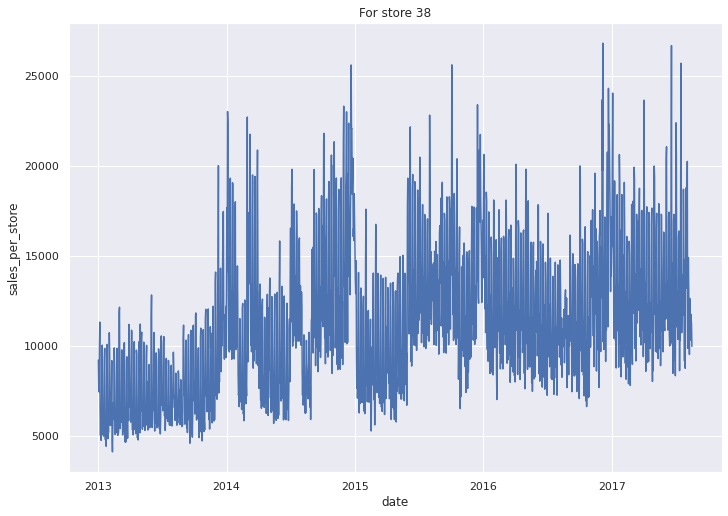

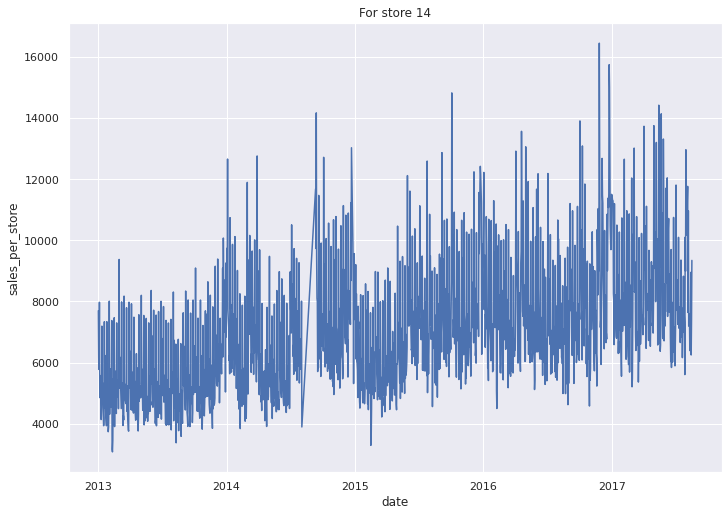

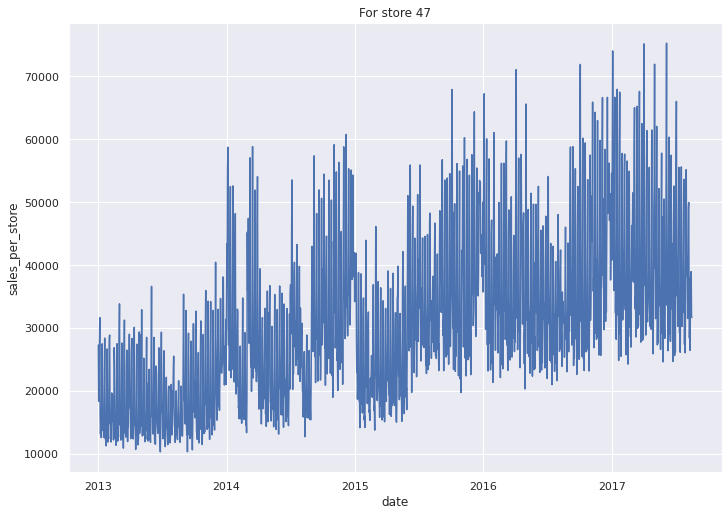

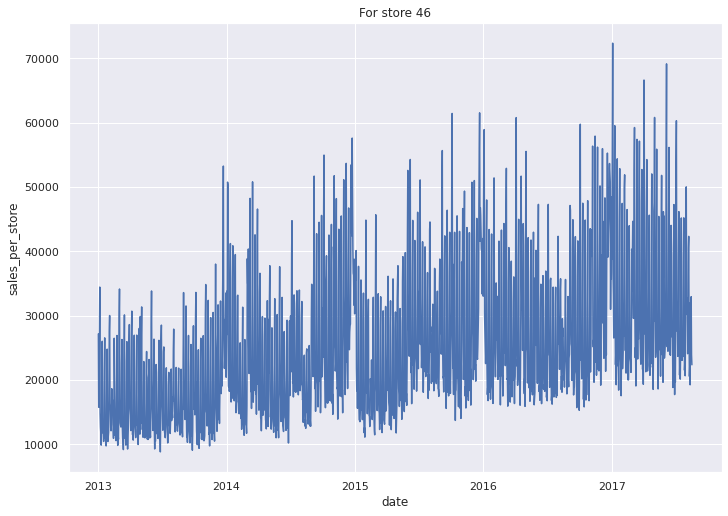

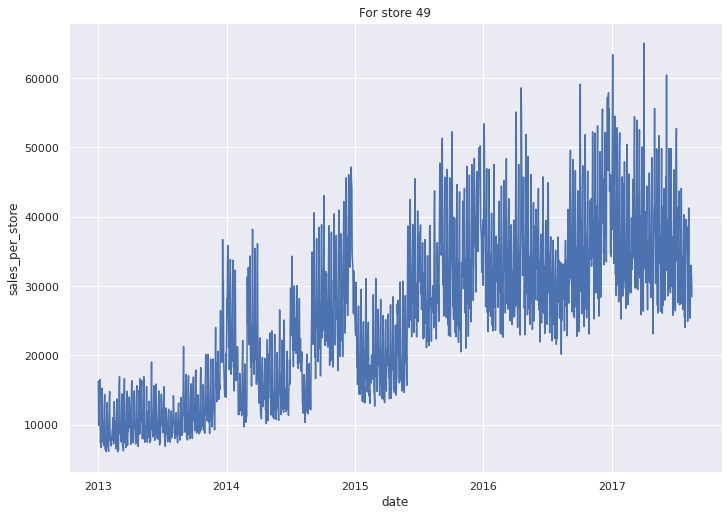

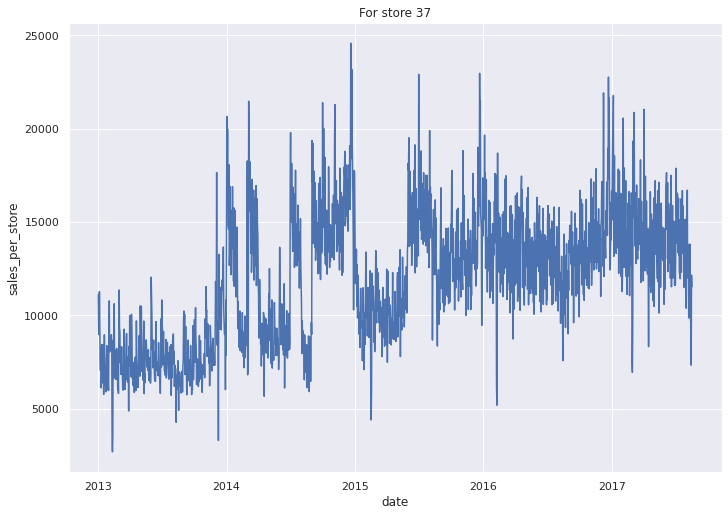

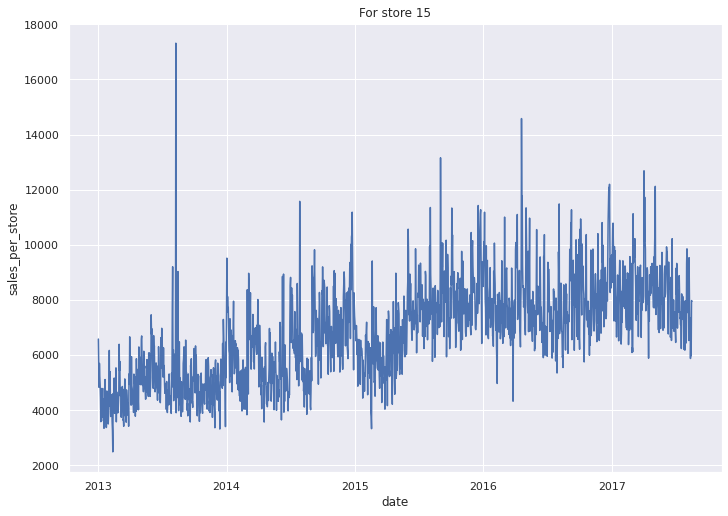

In [0]:
for i in range(10):
  plot_line_plot(date_store_level_data[date_store_level_data['store_nbr'] == store_list[i]]['date'], date_store_level_data[date_store_level_data['store_nbr'] == store_list[i]]['sales_per_store'], 'For store {}'.format(store_list[i]))

We plotted for 10 stores randomly to check the sale of a particular store over time, we did see some upward trends for few stores, but this may be due to the facts that new items are being sold in that store and so the overall sales have increased, overall the pattern were similar for most of the stores....

**Sales of an item over time**

In [0]:
date_item_level_sales = spark.sql('select date, item_nbr, SUM(unit_sales) as sales_per_item FROM data  GROUP BY date, item_nbr ORDER BY date').toPandas()
date_item_level_count = spark.sql('select date, item_nbr, COUNT(1) as sales_per_item FROM data  GROUP BY date, item_nbr ORDER BY date').toPandas()

In [0]:
date_item_level_sales.head()

date  item_nbr  sales_per_item
0  2013-01-01    749421             7.0
1  2013-01-01    913521             3.0
2  2013-01-01    587069             1.0
3  2013-01-01    636846             1.0
4  2013-01-01    802832             2.0

In [0]:
item_list = list(date_item_level_sales['item_nbr'].unique())

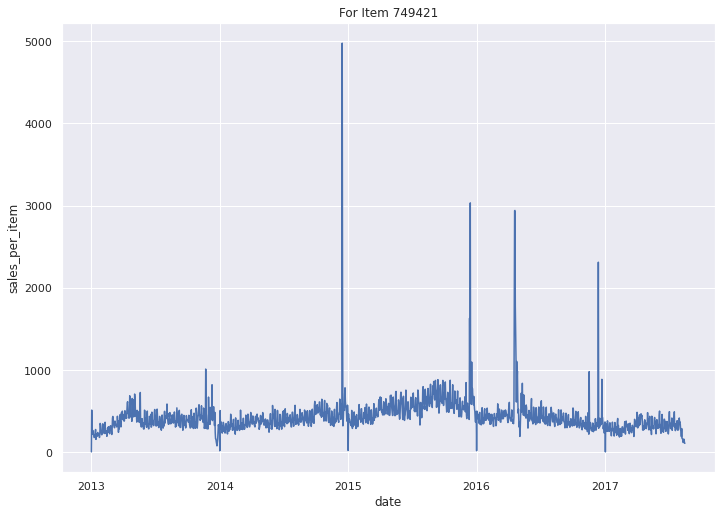

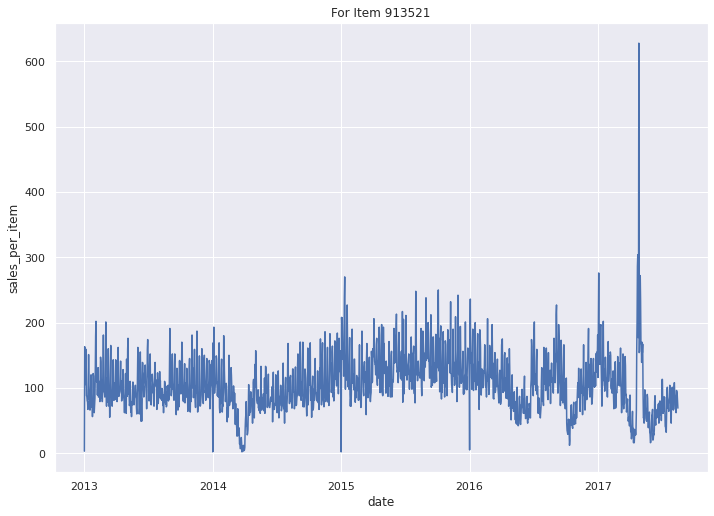

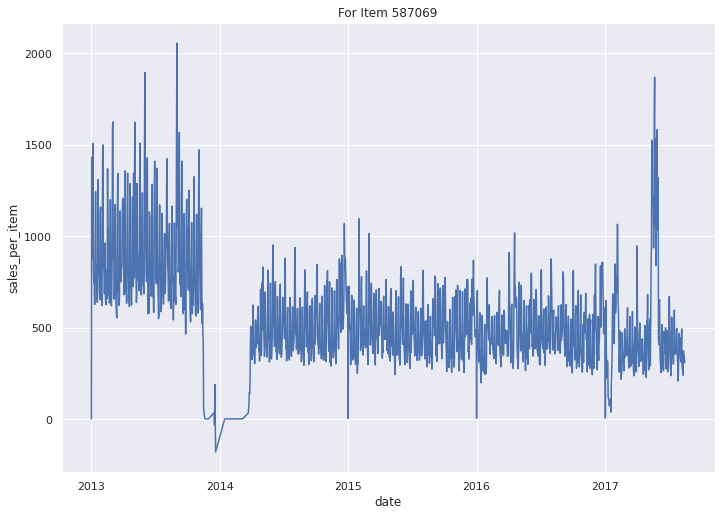

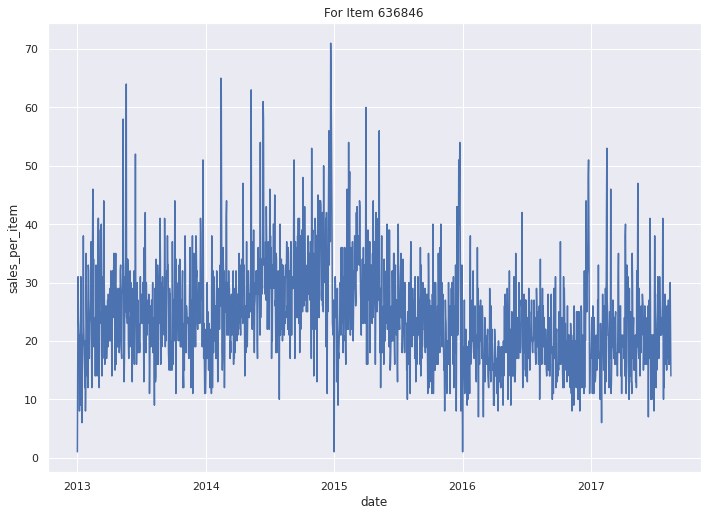

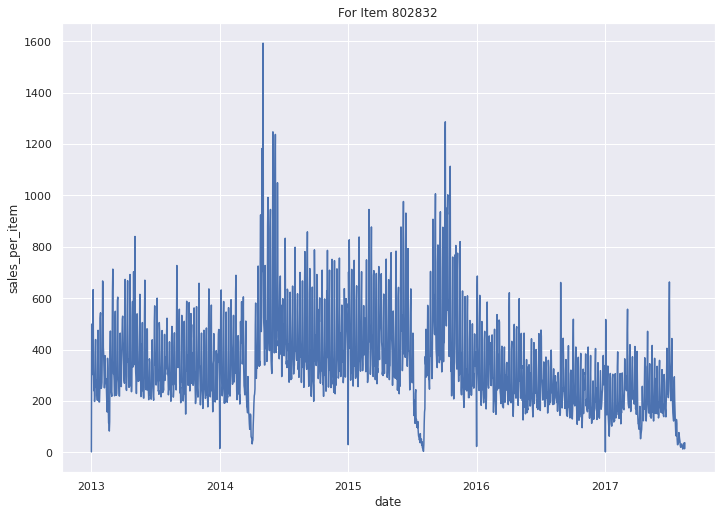

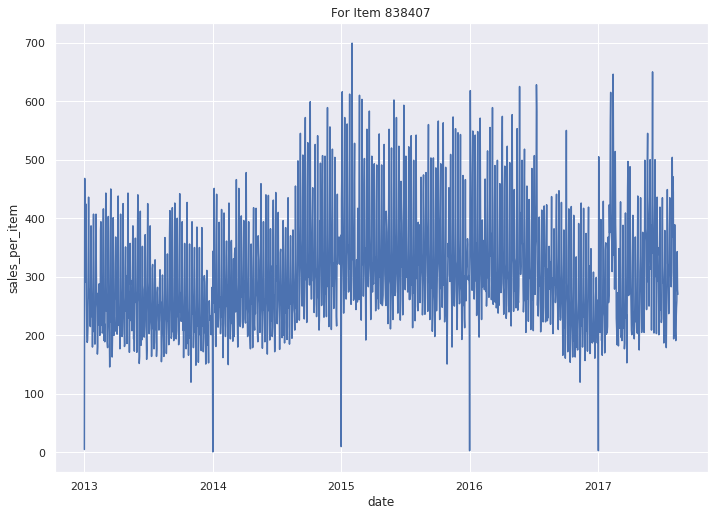

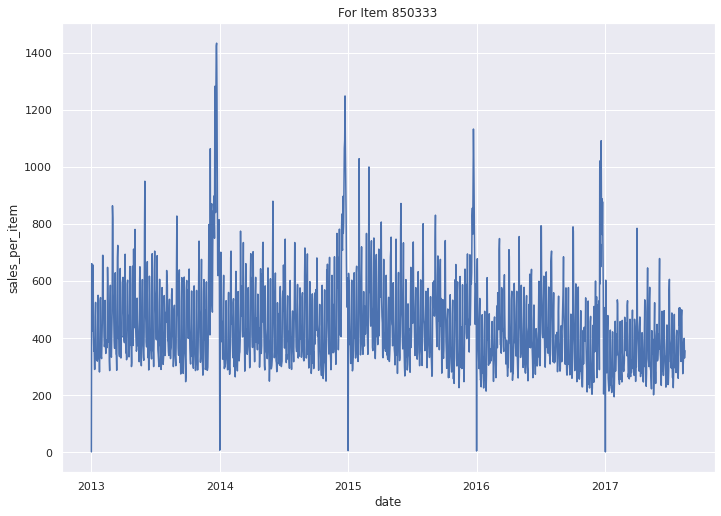

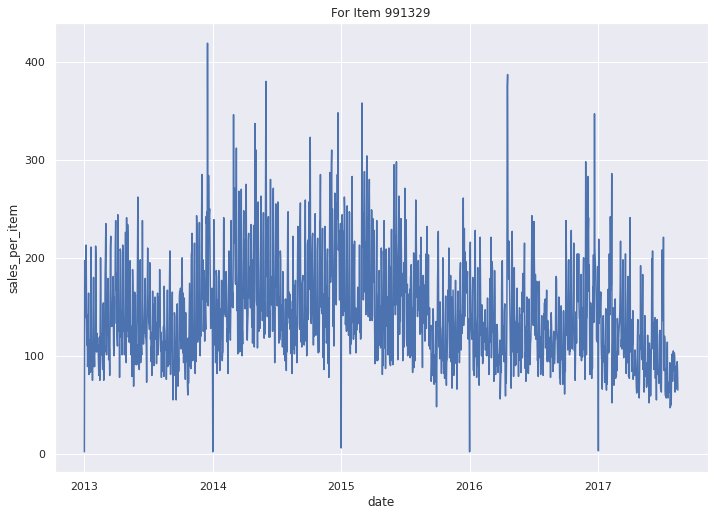

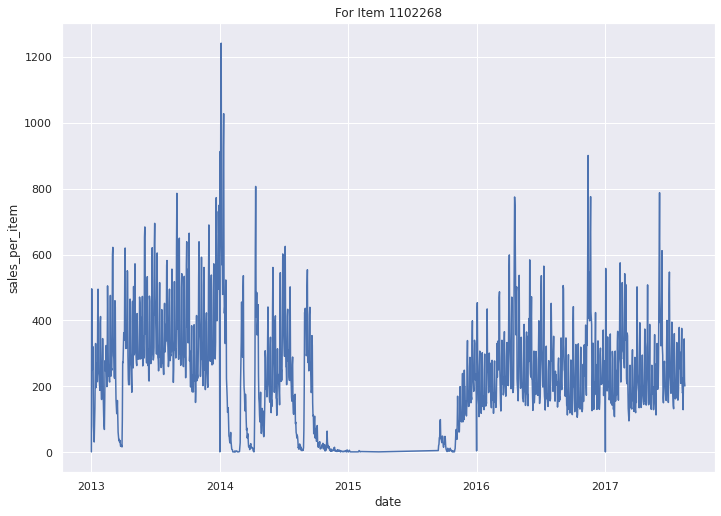

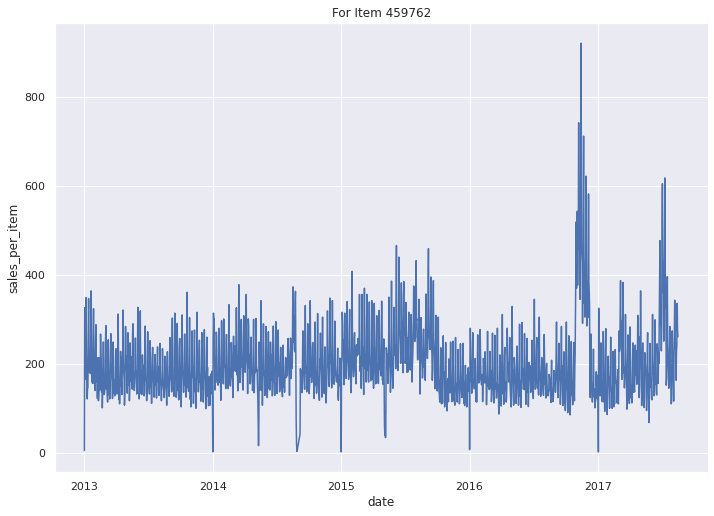

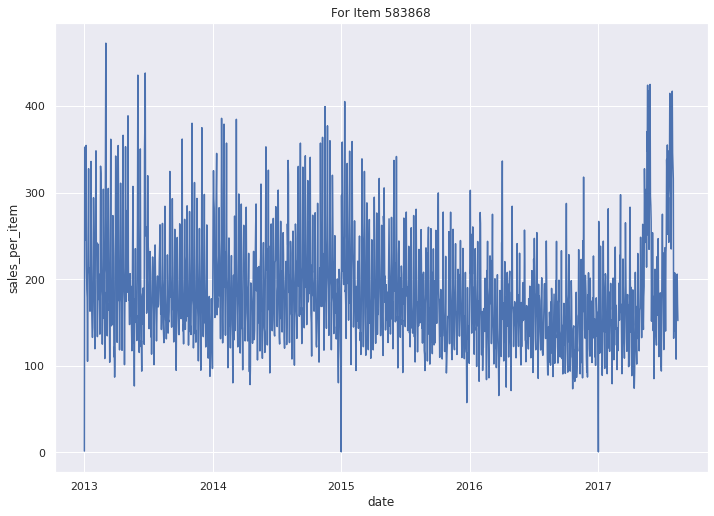

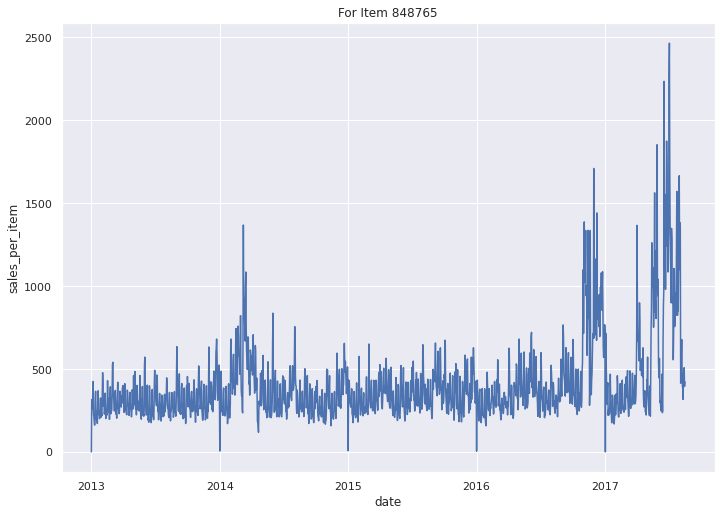

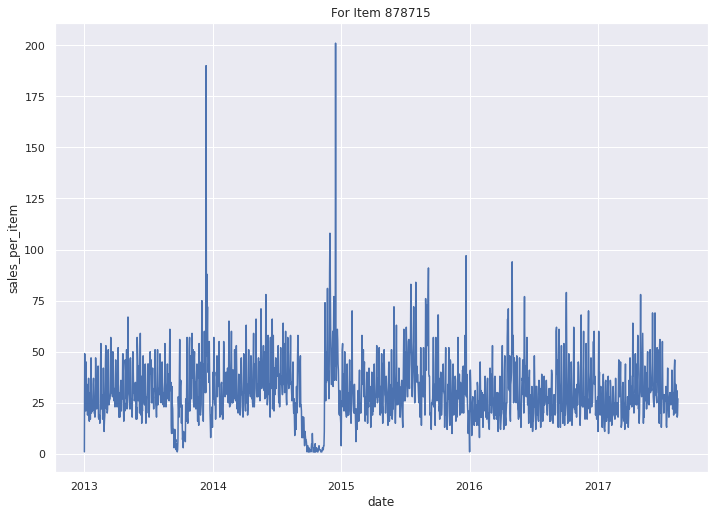

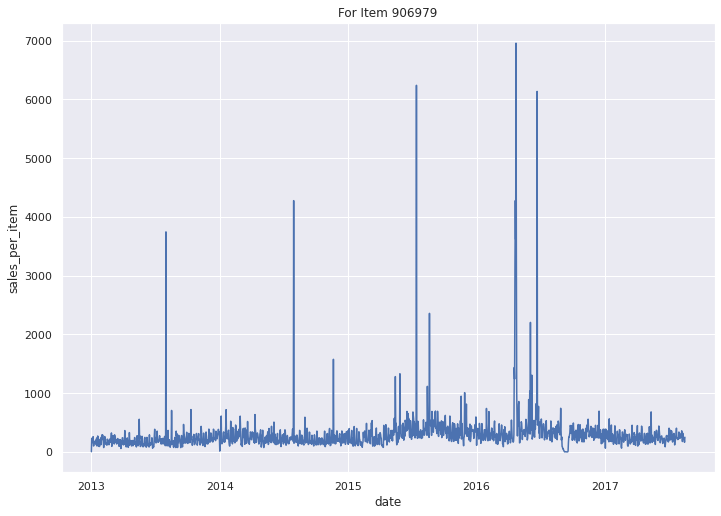

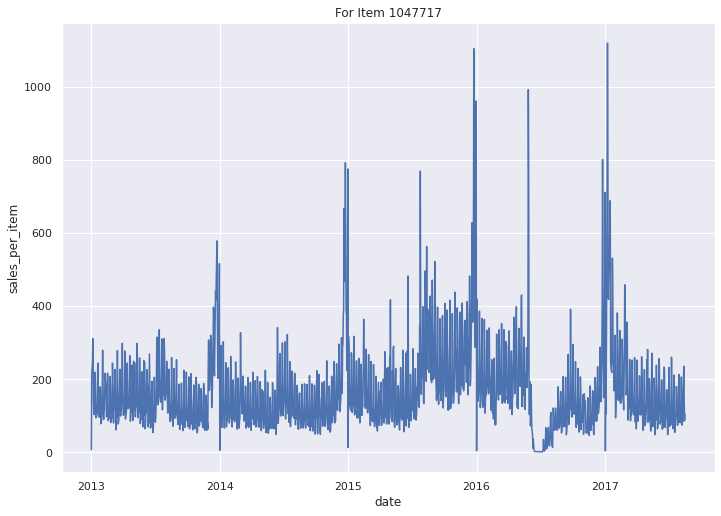

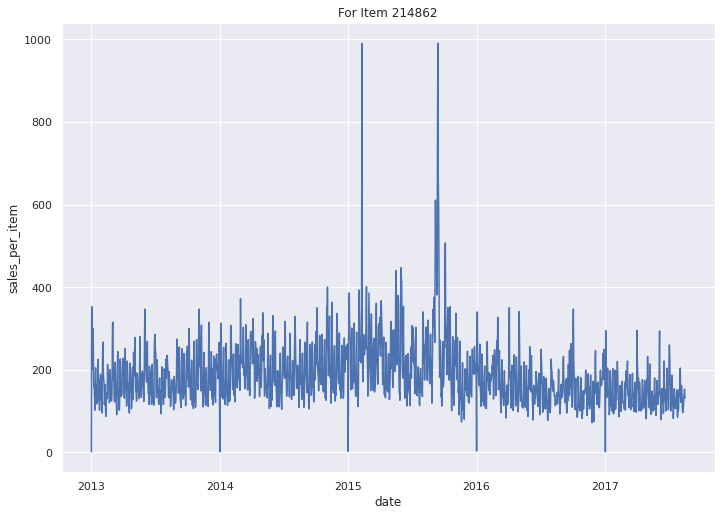

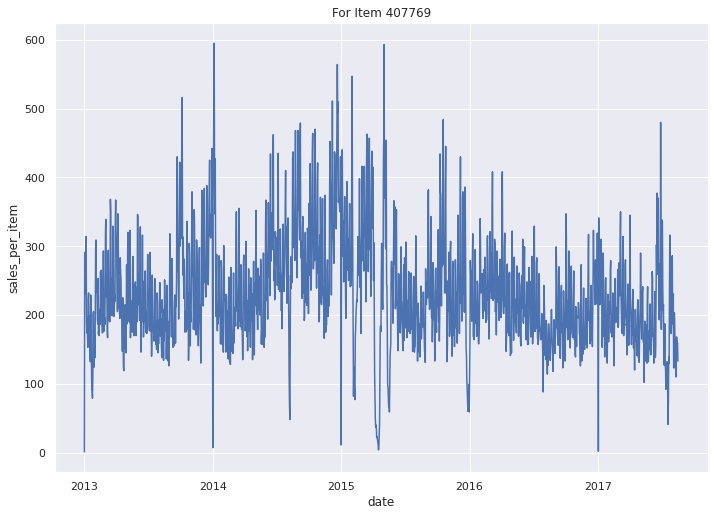

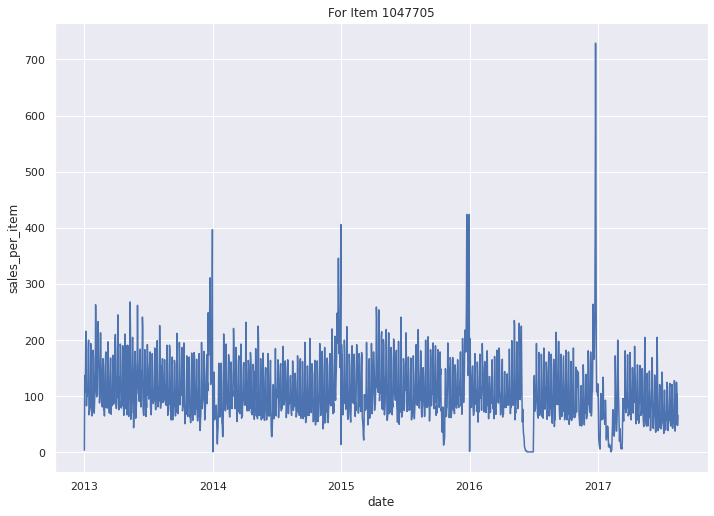

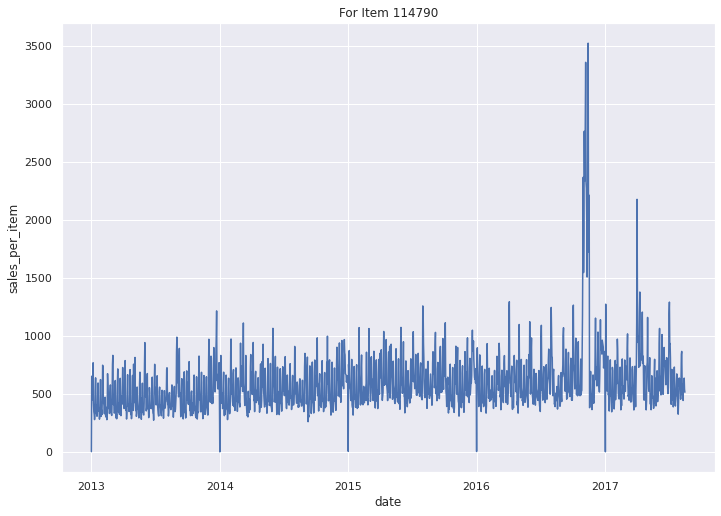

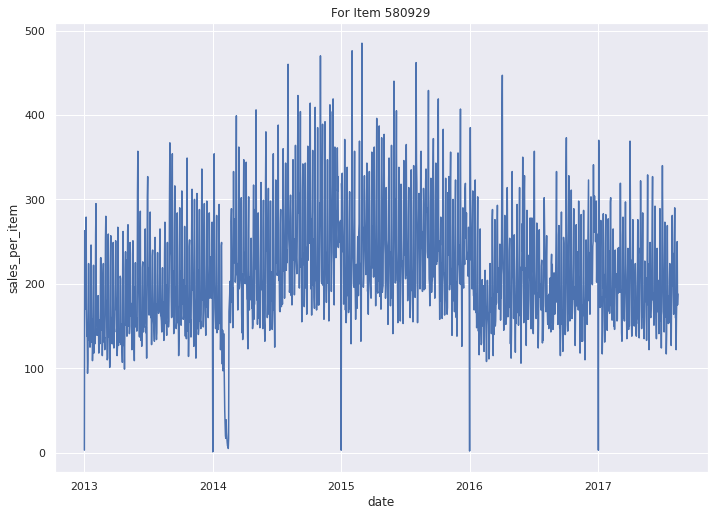

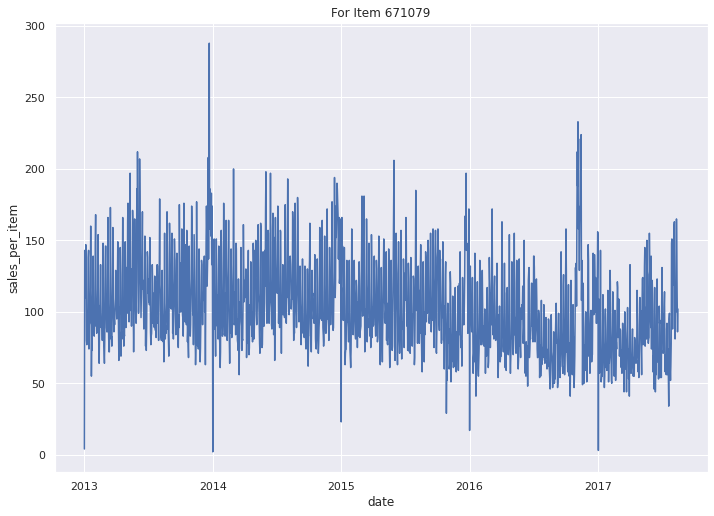

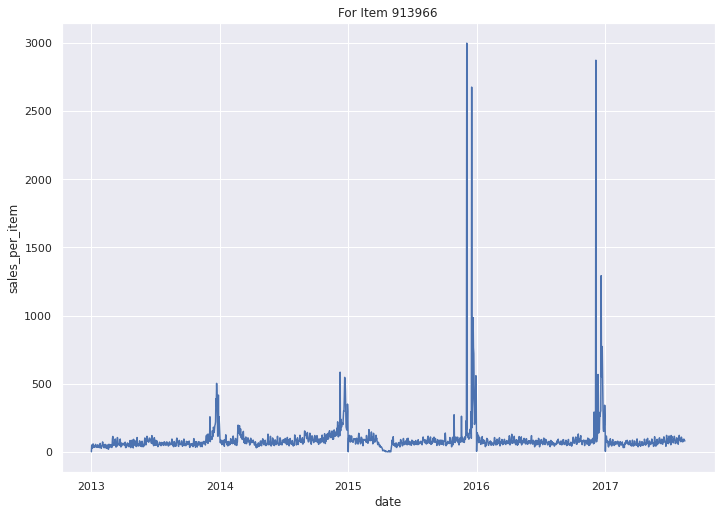

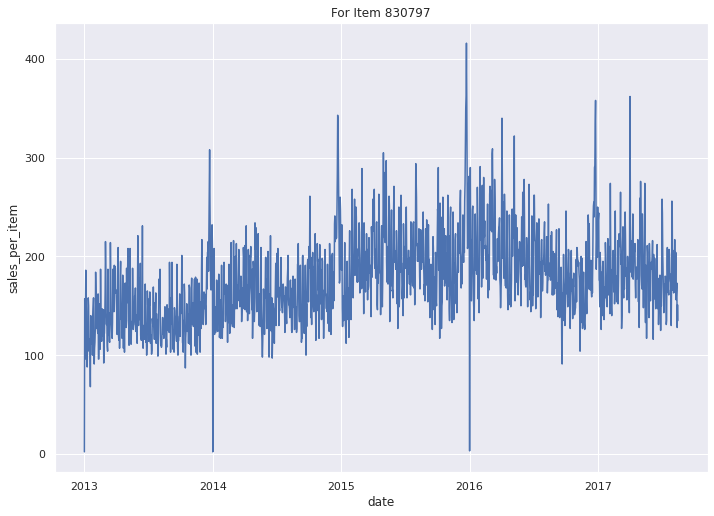

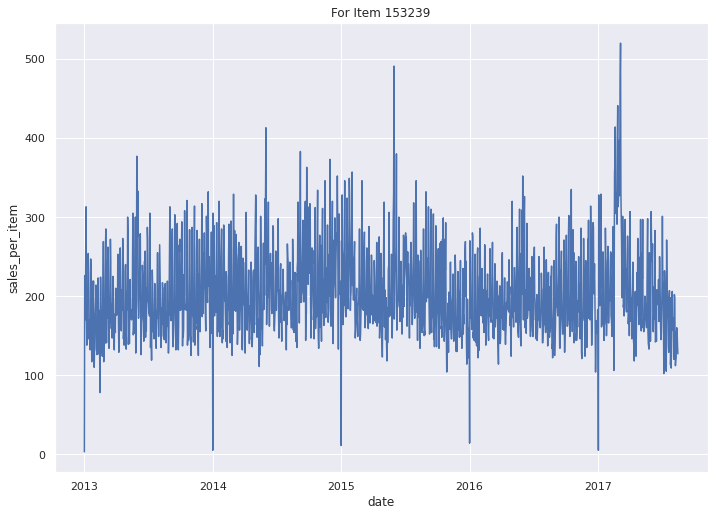

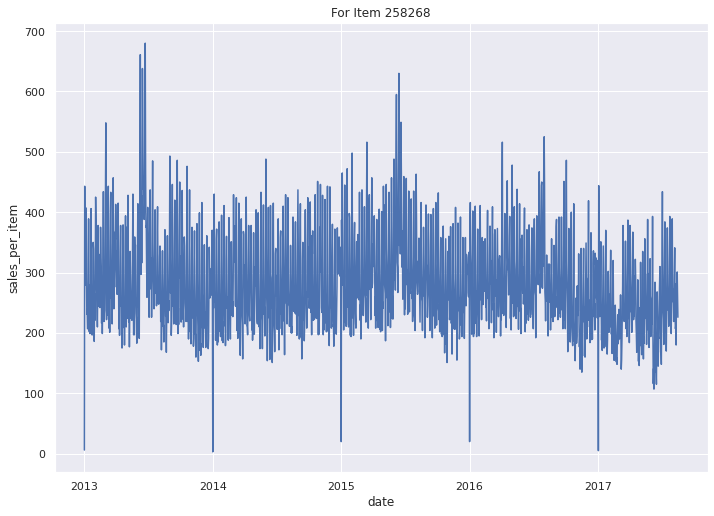

In [0]:
for i in range(25):
  plot_line_plot(date_item_level_sales[date_item_level_sales['item_nbr'] == item_list[i]]['date'], date_item_level_sales[date_item_level_sales['item_nbr'] == item_list[i]]['sales_per_item'], 'For Item {}'.format(item_list[i]))

So, Tried plotting 25 time series which is a very small sample if we talk about the whole population of items, but things that were interesting were that non of these items showed a trend, also, items did showed some cyclic behaviour and sesonality, for a item the sales dropped to almost 0 for some part of the year and few items had mixed signal, but most of the items had good signals to forecast....

**Let's see the most popular items across the chain**

In [0]:
date_item_level_count.head()

date  item_nbr  sales_per_item
0  2013-01-01    749421               1
1  2013-01-01    913521               1
2  2013-01-01    587069               1
3  2013-01-01    636846               1
4  2013-01-01    802832               1

In [0]:
date_item_level_count.groupby('item_nbr').sum().sort_values('sales_per_item', ascending = False).head(20)

sales_per_item
item_nbr                
502331             83475
314384             83450
364606             83308
265559             83047
559870             82513
1036689            82134
273528             82108
564533             82086
261052             81774
414353             81755
1084881            81324
839363             81268
850333             81097
414750             81091
847863             80947
581078             80776
1047679            80713
258396             80574
759893             80499
841842             80419

These are the top items with maximum total sales....

<h1> Store Data </h1>

In [0]:
stores_df.printSchema()

root
 |-- store_nbr: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- type: string (nullable = true)
 |-- cluster: string (nullable = true)



In [0]:
stores_df.show()

+---------+-------------+--------------------+----+-------+
|store_nbr|         city|               state|type|cluster|
+---------+-------------+--------------------+----+-------+
|        1|        Quito|           Pichincha|   D|     13|
|        2|        Quito|           Pichincha|   D|     13|
|        3|        Quito|           Pichincha|   D|      8|
|        4|        Quito|           Pichincha|   D|      9|
|        5|Santo Domingo|Santo Domingo de ...|   D|      4|
|        6|        Quito|           Pichincha|   D|     13|
|        7|        Quito|           Pichincha|   D|      8|
|        8|        Quito|           Pichincha|   D|      8|
|        9|        Quito|           Pichincha|   B|      6|
|       10|        Quito|           Pichincha|   C|     15|
|       11|      Cayambe|           Pichincha|   B|      6|
|       12|    Latacunga|            Cotopaxi|   C|     15|
|       13|    Latacunga|            Cotopaxi|   C|     15|
|       14|     Riobamba|          Chimb

In [0]:
stores_df.dtypes

[('store_nbr', 'string'),
 ('city', 'string'),
 ('state', 'string'),
 ('type', 'string'),
 ('cluster', 'string')]

In [0]:
stores_df = stores_df.withColumn('store_nbr', col('store_nbr').cast(IntegerType())).withColumn('cluster', col('cluster').cast(IntegerType()))

In [0]:
stores_df.dtypes

[('store_nbr', 'int'),
 ('city', 'string'),
 ('state', 'string'),
 ('type', 'string'),
 ('cluster', 'int')]

In [0]:
stores_df.createOrReplaceTempView('store_data')
stores_df.cache

<bound method DataFrame.cache of DataFrame[store_nbr: int, city: string, state: string, type: string, cluster: int]>

In [0]:
store_type = spark.sql('select type, count(1) count FROM store_data GROUP BY type').toPandas()
store_city = spark.sql('select city, count(1) count FROM store_data GROUP BY city').toPandas()
store_state = spark.sql('select state, count(1) count FROM store_data GROUP BY state').toPandas()
store_cluster = spark.sql('select cluster, count(1) count FROM store_data GROUP BY cluster ORDER BY cluster').toPandas()

In [0]:
def bar_plot(x, y, txt):
  sns.set(rc={'figure.figsize':(12,10)})
  sns.barplot(x, y)
  #Ref: https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh
  for index,data in enumerate(y):
    plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=20))
  plt.title(txt)
  plt.xticks(rotation=90)
  plt.show()

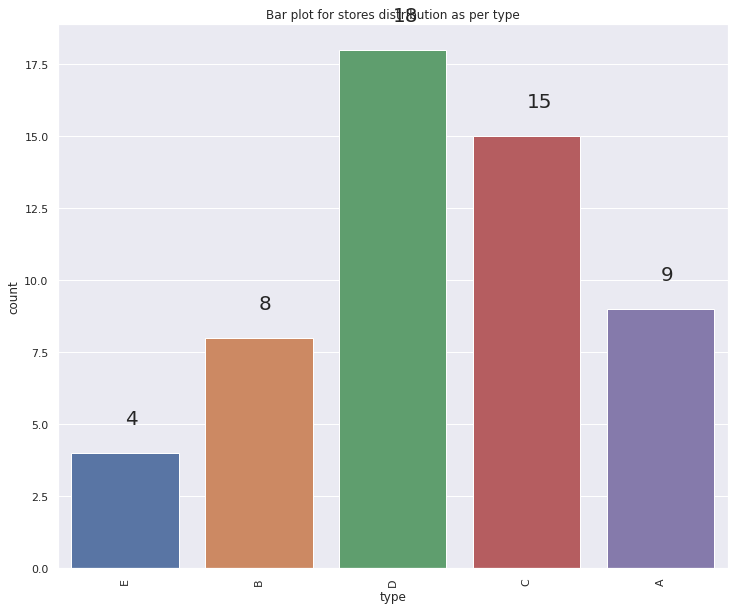

In [0]:
bar_plot(store_type['type'], store_type['count'], 'Bar plot for stores distribution as per type')

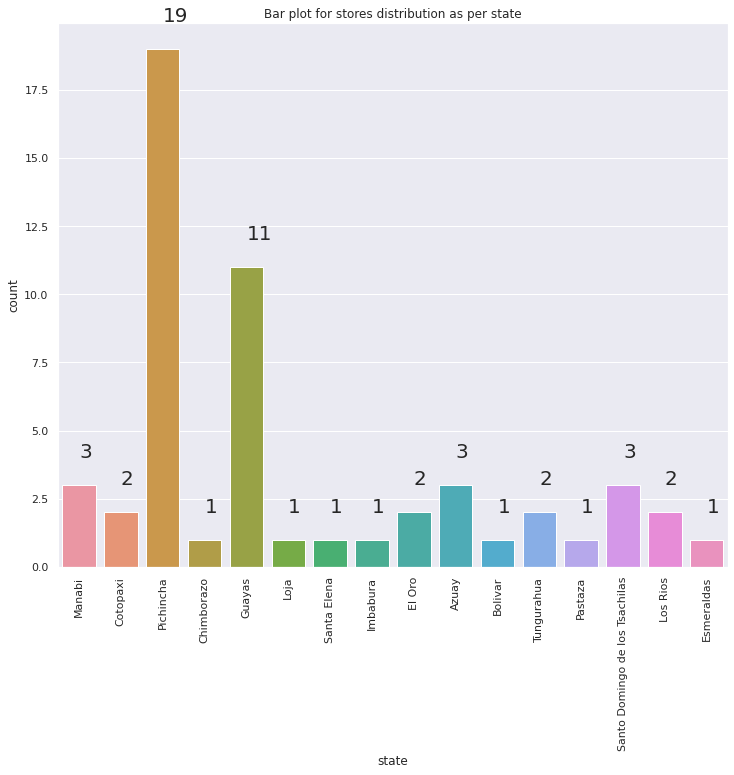

In [0]:
bar_plot(store_state['state'], store_state['count'], 'Bar plot for stores distribution as per state')

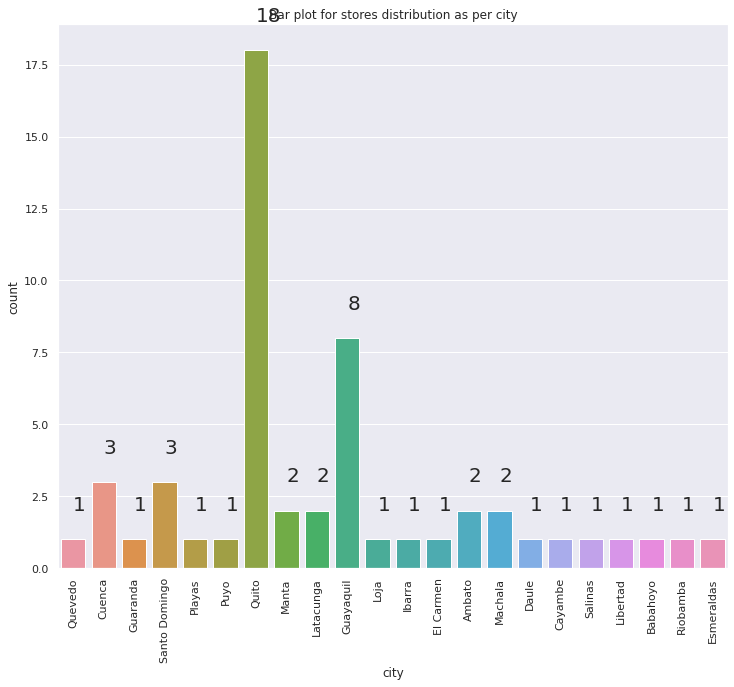

In [0]:
bar_plot(store_city['city'], store_city['count'], 'Bar plot for stores distribution as per city')

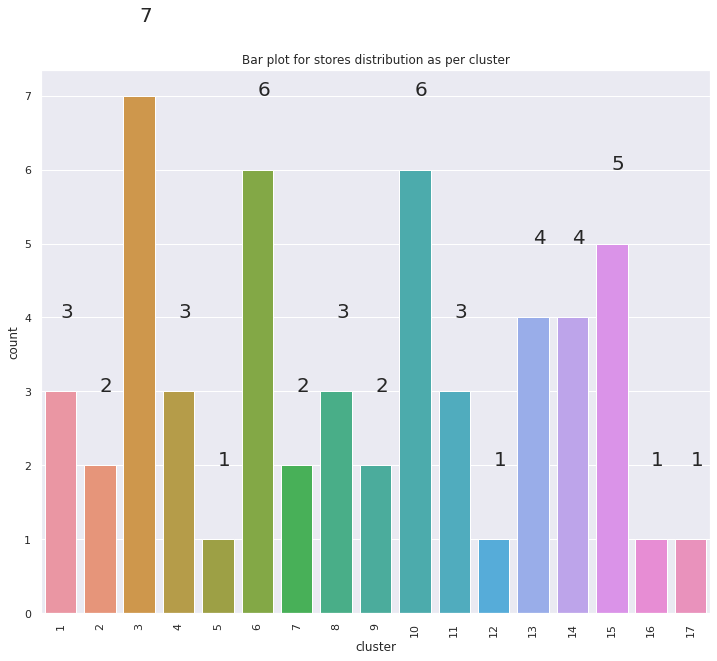

In [0]:
bar_plot(store_cluster['cluster'], store_cluster['count'], 'Bar plot for stores distribution as per cluster')

From all of the plots for stores we can say that:

1) Among the types, we see that D and C are the most frequent, with A and B having similar medium frequency and E only accounting for 4 stores.

2) The cities fall into four groups, with most of them having only a single store. Six cities have 2 or 3 stores. “Guayaquil” and the capital “Quito” are each in a group of their own with 8 and 18 stores, respectively.

3) The city distribution is reflected in the state distribution as well, with “Pichincha” having 19 stores, “Guayas” 11, and the rest between 1 and 3.

4) The cluster feature shows a range from 1 to 7.

<h2> Total sales by type </h1>

In [0]:
type_sales = spark.sql('''SELECT s.type, SUM(d.unit_sales) AS total_sales FROM data d LEFT JOIN store_data s ON d.store_nbr = s.store_nbr 
                          GROUP BY s.type ORDER BY total_sales DESC''').toPandas()

Text(0.5, 1.0, 'PLot showing total sales distribution on store type')

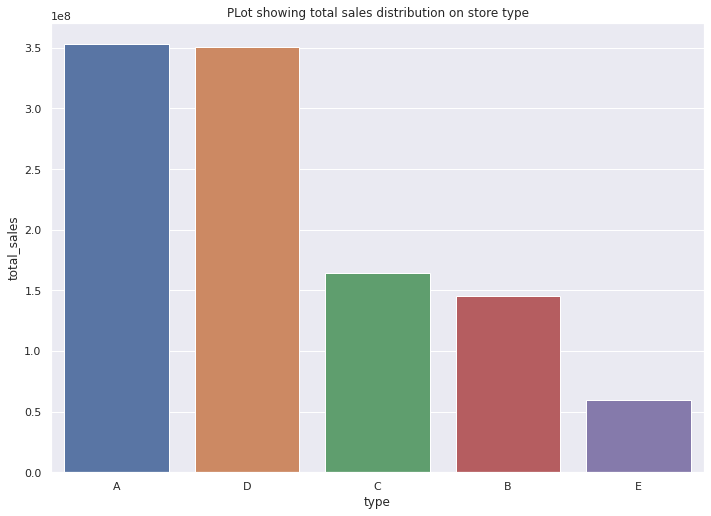

In [0]:
sns.barplot(type_sales['type'], type_sales['total_sales'])
plt.title('PLot showing total sales distribution on store type')

Again type A and D corresponds to the maximum number of sales.

<h2> Total sales by cluster </h1>

In [0]:
cluster_sales = spark.sql('select s.cluster, SUM(d.unit_sales) as total_sales from data d LEFT JOIN store_data s on d.store_nbr = s.store_nbr GROUP BY s.cluster ORDER BY total_sales DESC').toPandas()

Text(0.5, 1.0, 'Plot showing total sales distribution on store cluster')

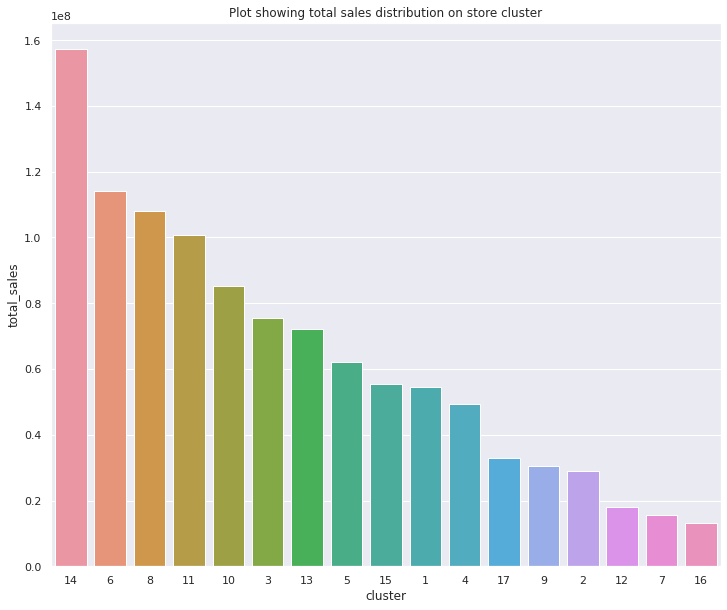

In [0]:
sns.barplot(cluster_sales['cluster'], cluster_sales['total_sales'], order=cluster_sales.sort_values('total_sales',ascending = False).cluster)
plt.title('Plot showing total sales distribution on store cluster')

<h1> Total Sales by State </h1>

In [0]:
state_sales = spark.sql('select s.state, SUM(d.unit_sales) as total_sales from data d LEFT JOIN store_data s on d.store_nbr = s.store_nbr GROUP BY s.state ORDER BY total_sales DESC').toPandas()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

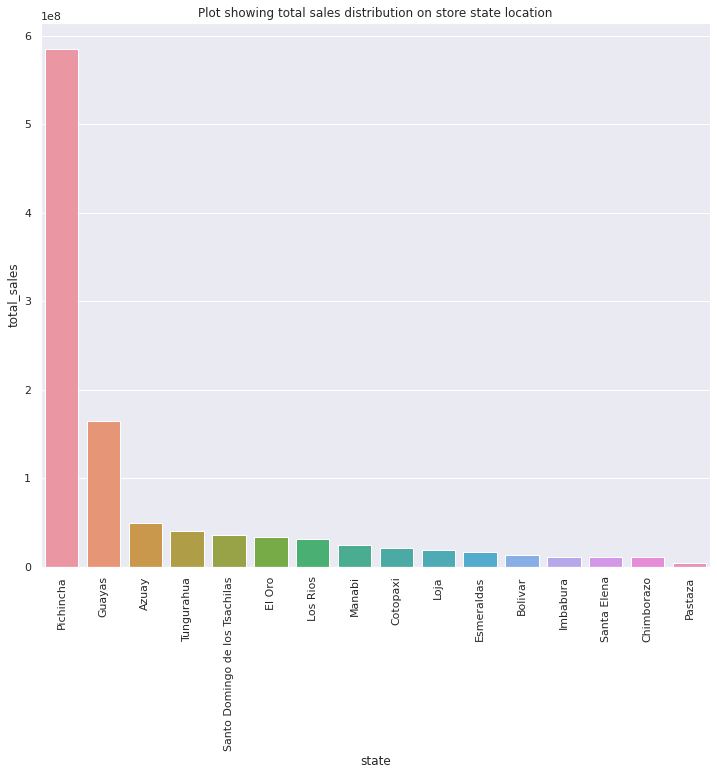

In [0]:
sns.barplot(state_sales['state'], state_sales['total_sales'])
plt.title('Plot showing total sales distribution on store state location')
plt.xticks(rotation=90)

Pichincha corresponds to maimum number of sales

<h1> Total sales by city </h1>

In [0]:
city_sales = spark.sql('select s.city, SUM(d.unit_sales) as total_sales from data d LEFT JOIN store_data s on d.store_nbr = s.store_nbr GROUP BY s.city ORDER BY total_sales DESC').toPandas()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text major ticklabel objects>)

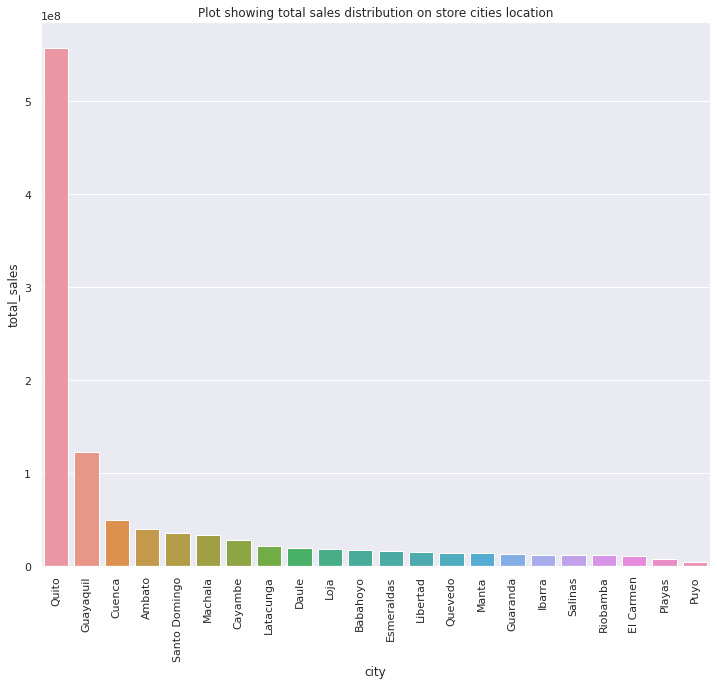

In [0]:
sns.barplot(city_sales['city'], city_sales['total_sales'])
plt.title('Plot showing total sales distribution on store cities location')
plt.xticks(rotation=90)

Most of the sales are seen in Quito and then in Guayaquil....

<h1> Item Data </h1>

In [0]:
items_df.printSchema()

root
 |-- item_nbr: string (nullable = true)
 |-- family: string (nullable = true)
 |-- class: string (nullable = true)
 |-- perishable: string (nullable = true)



In [0]:
items_df.show()

+--------+------------+-----+----------+
|item_nbr|      family|class|perishable|
+--------+------------+-----+----------+
|   96995|   GROCERY I| 1093|         0|
|   99197|   GROCERY I| 1067|         0|
|  103501|    CLEANING| 3008|         0|
|  103520|   GROCERY I| 1028|         0|
|  103665|BREAD/BAKERY| 2712|         1|
|  105574|   GROCERY I| 1045|         0|
|  105575|   GROCERY I| 1045|         0|
|  105576|   GROCERY I| 1045|         0|
|  105577|   GROCERY I| 1045|         0|
|  105693|   GROCERY I| 1034|         0|
|  105737|   GROCERY I| 1044|         0|
|  105857|   GROCERY I| 1092|         0|
|  106716|   GROCERY I| 1032|         0|
|  108079|   GROCERY I| 1030|         0|
|  108634|   GROCERY I| 1075|         0|
|  108696|        DELI| 2636|         1|
|  108698|        DELI| 2644|         1|
|  108701|        DELI| 2644|         1|
|  108786|    CLEANING| 3044|         0|
|  108797|   GROCERY I| 1004|         0|
+--------+------------+-----+----------+
only showing top

In [0]:
items_df.dtypes

[('item_nbr', 'string'),
 ('family', 'string'),
 ('class', 'string'),
 ('perishable', 'string')]

In [0]:
items_df = items_df.withColumn('item_nbr', col('item_nbr').cast(IntegerType())).withColumn('class', col('class').cast(IntegerType())).withColumn('perishable', col('perishable').cast(IntegerType()))

In [0]:
items_df.dtypes

[('item_nbr', 'int'),
 ('family', 'string'),
 ('class', 'int'),
 ('perishable', 'int')]

In [0]:
items_df.createOrReplaceTempView('items_data')
items_df.cache

<bound method DataFrame.cache of DataFrame[item_nbr: int, family: string, class: int, perishable: int]>

In [0]:
spark.sql('select COUNT(DISTINCT item_nbr) as total_items from items_data').show()

+-----------+
|total_items|
+-----------+
|       4100|
+-----------+



Total items in the file is 4100, in train file we saw total items to be 4036, 64 may be the items in the test file whose details are not available in train.

In [0]:
spark.sql('select COUNT(DISTINCT family) as all_family from items_data').show()

+----------+
|all_family|
+----------+
|        33|
+----------+



We have total 33 family of items

In [0]:
spark.sql('select COUNT(DISTINCT class) as all_class from items_data').show()

+---------+
|all_class|
+---------+
|      337|
+---------+



Total class of the items is 337

In [0]:
spark.sql('select perishable, COUNT(1) as count from items_data GROUP BY perishable').show()

+----------+-----+
|perishable|count|
+----------+-----+
|         1|  986|
|         0| 3114|
+----------+-----+



In [0]:
spark.sql('SELECT perishable, count, ROUND(count/SUM(count) OVER (), 2) as percent FROM (select perishable, COUNT(1) as count from items_data GROUP BY perishable) ').show()

+----------+-----+-------+
|perishable|count|percent|
+----------+-----+-------+
|         1|  986|   0.24|
|         0| 3114|   0.76|
+----------+-----+-------+



24 % of the items stored in the store are perishable....

**Let's look at items by Item Family**

In [0]:
spark.sql('select family, count(Distinct item_nbr) as item_count from items_data GROUP BY family ORDER BY item_count DESC').show()

+-------------------+----------+
|             family|item_count|
+-------------------+----------+
|          GROCERY I|      1334|
|          BEVERAGES|       613|
|           CLEANING|       446|
|            PRODUCE|       306|
|              DAIRY|       242|
|      PERSONAL CARE|       153|
|       BREAD/BAKERY|       134|
|          HOME CARE|       108|
|               DELI|        91|
|              MEATS|        84|
| HOME AND KITCHEN I|        77|
|   LIQUOR,WINE,BEER|        73|
|       FROZEN FOODS|        55|
|            POULTRY|        54|
|HOME AND KITCHEN II|        45|
|               EGGS|        41|
|        CELEBRATION|        31|
|    LAWN AND GARDEN|        26|
|     PREPARED FOODS|        26|
|         LADIESWEAR|        21|
+-------------------+----------+
only showing top 20 rows



Let's plot this

In [0]:
itm_family = spark.sql('select family, count(Distinct item_nbr) as item_count from items_data GROUP BY family ORDER BY item_count DESC').toPandas()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 33 Text major ticklabel objects>)

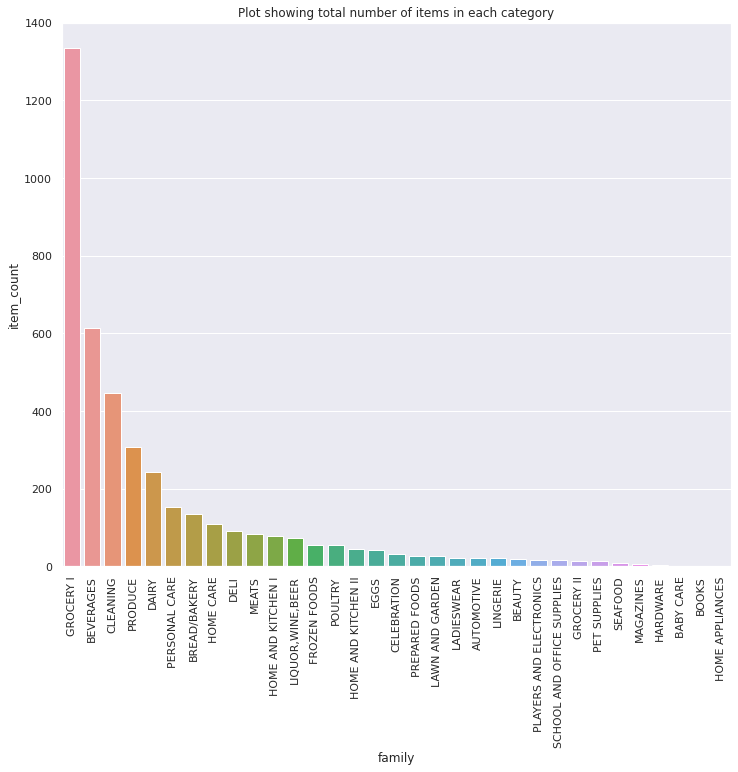

In [0]:
sns.barplot(itm_family['family'], itm_family['item_count'])
plt.title('Plot showing total number of items in each category')
plt.xticks(rotation=90)

As expected Grocery, Beverages, cleaning, prodice, dairy contains most of the items....

**Let see how many class of items have not more than 2 items**

In [0]:
item_class_count = spark.sql('select class, count(Distinct item_nbr) as item_count from items_data GROUP BY class ORDER BY item_count DESC').toPandas()

In [0]:
item_class_count[item_class_count['item_count'] <=  2]['class'].nunique()

118

In total we have 337 classes, out of these 118 Classes have items less than or equal to 2.

**Checking relationship between classes and family**

In [0]:
class_family_item_group = spark.sql('select class, family, count(DISTINCT item_nbr) as item_count FROM items_data GROUP BY class, family').toPandas()

In [0]:
class_family_item_group[class_family_item_group['family'] == 'GROCERY I']

class     family  item_count
1     1079  GROCERY I           1
5     1058  GROCERY I          16
11    1054  GROCERY I           2
13    1076  GROCERY I          23
16    1024  GROCERY I           4
..     ...        ...         ...
302   1045  GROCERY I          24
306   1096  GROCERY I          18
309   1029  GROCERY I           1
319   1067  GROCERY I           2
328   1027  GROCERY I           2

[67 rows x 3 columns]

Have checked for various families, and now it is known that classes are the sub group of families, but this is the only info we have, combining with other data present will tell us of the predictive importance of this data.

<h1> Transaction Data </h1>

In [0]:
transactions_df.printSchema()

root
 |-- date: string (nullable = true)
 |-- store_nbr: string (nullable = true)
 |-- transactions: string (nullable = true)



In [0]:
transactions_df.show()

+----------+---------+------------+
|      date|store_nbr|transactions|
+----------+---------+------------+
|2013-01-01|       25|         770|
|2013-01-02|        1|        2111|
|2013-01-02|        2|        2358|
|2013-01-02|        3|        3487|
|2013-01-02|        4|        1922|
|2013-01-02|        5|        1903|
|2013-01-02|        6|        2143|
|2013-01-02|        7|        1874|
|2013-01-02|        8|        3250|
|2013-01-02|        9|        2940|
|2013-01-02|       10|        1293|
|2013-01-02|       11|        3547|
|2013-01-02|       12|        1362|
|2013-01-02|       13|        1102|
|2013-01-02|       14|        2002|
|2013-01-02|       15|        1622|
|2013-01-02|       16|        1167|
|2013-01-02|       17|        1580|
|2013-01-02|       18|        1635|
|2013-01-02|       19|        1369|
+----------+---------+------------+
only showing top 20 rows



In [0]:
transactions_df.count()

83488

In [0]:
transactions_df.dtypes

[('date', 'string'), ('store_nbr', 'string'), ('transactions', 'string')]

In [0]:
transactions_df = transactions_df.withColumn('date', col('date').cast(DateType())).withColumn('store_nbr', col('store_nbr').cast(IntegerType())).withColumn('transactions', col('transactions').cast(IntegerType()))

In [0]:
transactions_df.dtypes

[('date', 'date'), ('store_nbr', 'int'), ('transactions', 'int')]

In [0]:
transactions_df.createOrReplaceTempView('transactions_data')
transactions_df.cache

<bound method DataFrame.cache of DataFrame[date: date, store_nbr: int, transactions: int]>

**Let us start by plotting transactions signals to see how they look**

In [0]:
transaction_date_agg = spark.sql('select date, SUM(transactions) as total_transaction FROM transactions_data GROUP BY date ORDER BY date').toPandas()

In [0]:
transaction_date_agg.head()

date  total_transaction
0  2013-01-01                770
1  2013-01-02              93215
2  2013-01-03              78504
3  2013-01-04              78494
4  2013-01-05              93573

Text(0.5, 1.0, 'Plot of total transactions over time(daily)')

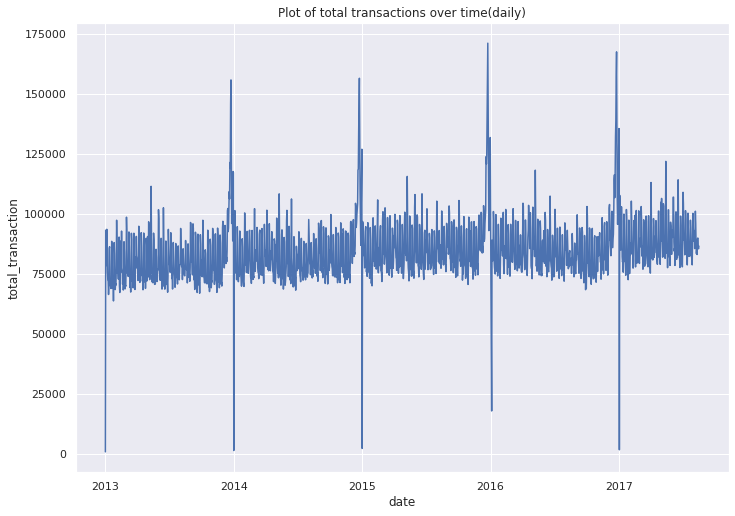

In [0]:
sns.lineplot(x=transaction_date_agg['date'], y=transaction_date_agg['total_transaction'])
plt.title('Plot of total transactions over time(daily)')

We find that there is a strong spike before Christmas, with corresponding drops when the stores are presumably closed during the holidays. Overall, the sales appear to be stable throughout this time range.



**Plotting for year 2015**

Text(0.5, 1.0, 'Plot of total transactions over time(daily) for year 2015')

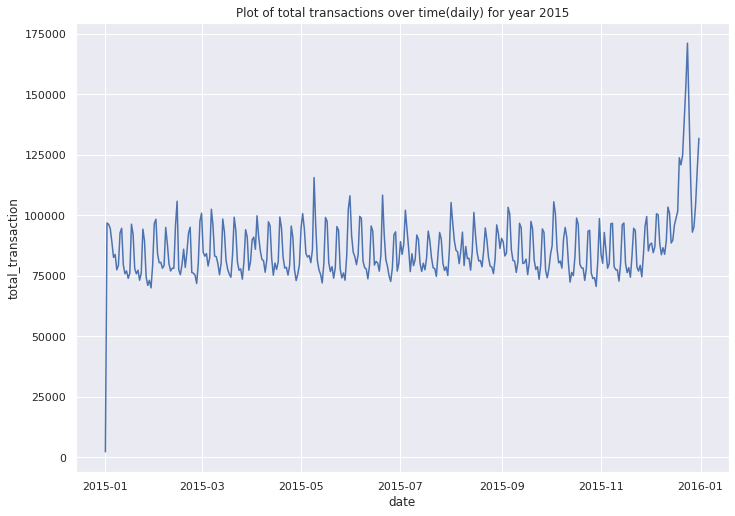

In [0]:
import datetime
start_index = transaction_date_agg[transaction_date_agg['date'] == datetime.date(2015, 1, 1)].index[0]
end_index = transaction_date_agg[transaction_date_agg['date'] == datetime.date(2015, 12, 31)].index[0]

year_2015_df = transaction_date_agg.loc[start_index : end_index]
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x=year_2015_df['date'], y=year_2015_df['total_transaction'])
plt.title('Plot of total transactions over time(daily) for year 2015')

When we tried plotting for year 2015, we saw the saw observation as see when plotted yearly...

Let us aggragate date weekly and monthly and see how our plot looks like...

In [0]:
transaction_date_agg['week'] = transaction_date_agg['date'].apply(lambda x : x.isocalendar()[1])
transaction_date_agg['month'] = transaction_date_agg['date'].apply(lambda x : x.month)
transaction_date_agg['year'] = transaction_date_agg['date'].apply(lambda x : x.year)

Text(0.5, 1.0, 'Plot of total transactions over time(weekly)')

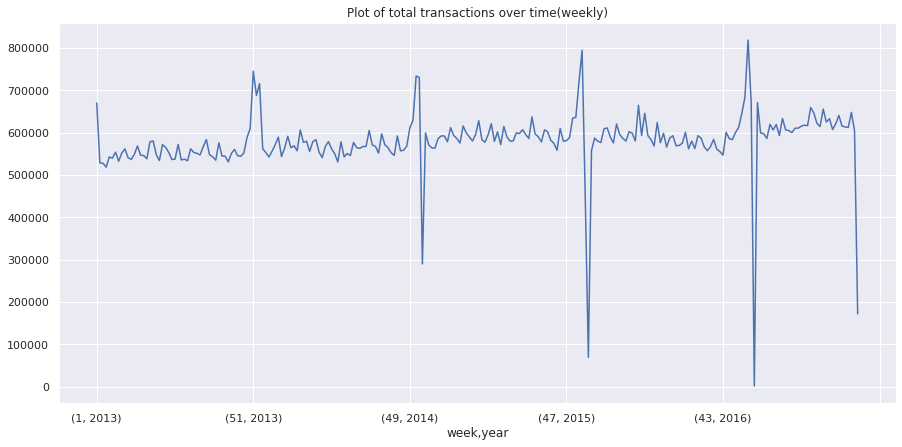

In [0]:
fig, ax = plt.subplots(figsize=(15,7))
transaction_date_agg.groupby(['week','year'], sort = False).sum()['total_transaction'].plot(ax=ax)
plt.title('Plot of total transactions over time(weekly)')

Text(0.5, 1.0, 'Plot of total transactions over time(Monthly)')

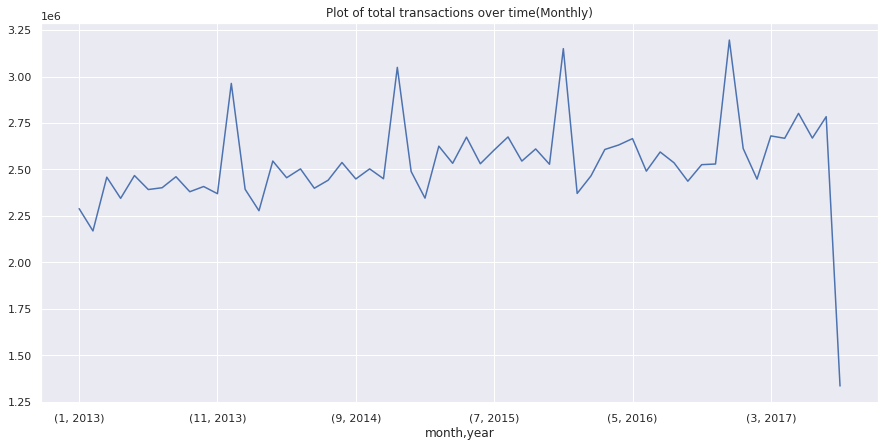

In [0]:
fig, ax = plt.subplots(figsize=(15,7))
transaction_date_agg.groupby(['month','year'], sort = False).sum()['total_transaction'].plot(ax=ax)
plt.title('Plot of total transactions over time(Monthly)')

These plots doesn't make much sense to us....

**Let us check the number of items purchased per transaction over the period**

In [0]:
spark.sql('''SELECT transactions_data.date,  total_sales/total_transaction as items_per_transaction 
FROM 
(select date, SUM(transactions) as total_transaction FROM transactions_data GROUP BY date ORDER BY date) as transactions_data 
INNER JOIN 
(select date, SUM(unit_sales) as total_sales FROM data WHERE unit_sales > 0 GROUP BY date ORDER BY date) as data 
ON transactions_data.date=data.date''').show()

+----------+---------------------+
|      date|items_per_transaction|
+----------+---------------------+
|2013-01-01|   3.2618428574754046|
|2013-01-02|    5.322055656274635|
|2013-01-03|    4.604699264327097|
|2013-01-04|    4.515914503734317|
|2013-01-05|    5.101440811699174|
|2013-01-06|   5.7447758334714205|
|2013-01-07|    4.446258463242334|
|2013-01-08|    4.401656107473159|
|2013-01-09|    4.204051757270201|
|2013-01-10|   3.9020080897907308|
|2013-01-11|    4.122575066501422|
|2013-01-12|    4.715922068776316|
|2013-01-13|   5.3836181497208795|
|2013-01-14|   4.1905642571400055|
|2013-01-15|    4.205858662957437|
|2013-01-16|    4.392895157657377|
|2013-01-17|   3.8839387852835032|
|2013-01-18|    4.149216559139545|
|2013-01-19|    4.883430655618284|
|2013-01-20|    5.406747682204343|
+----------+---------------------+
only showing top 20 rows



In [0]:
items_per_transaction_df = spark.sql('''SELECT transactions_data.date,  total_sales/total_transaction as items_per_transaction 
FROM 
(select date, SUM(transactions) as total_transaction FROM transactions_data GROUP BY date ORDER BY date) as transactions_data 
INNER JOIN 
(select date, SUM(unit_sales) as total_sales FROM data WHERE unit_sales > 0 GROUP BY date ORDER BY date) as data 
ON transactions_data.date=data.date''').toPandas()

Text(0.5, 1.0, 'Plot for items purchased per transaction')

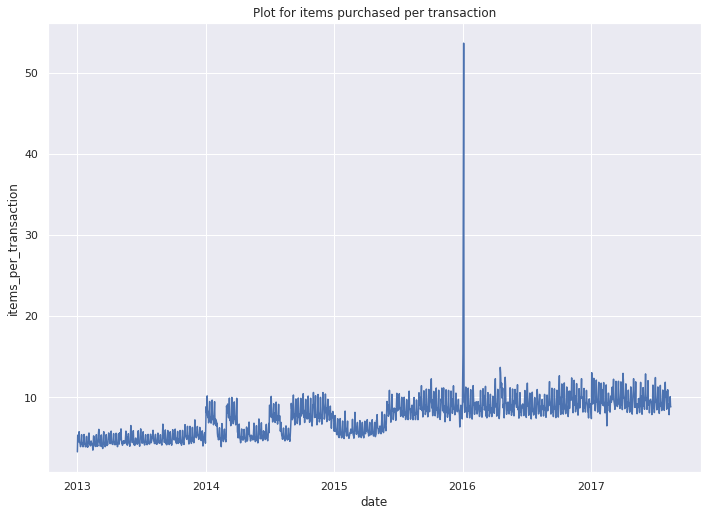

In [0]:
sns.lineplot(x=items_per_transaction_df['date'], y=items_per_transaction_df['items_per_transaction'])
plt.title('Plot for items purchased per transaction')

Number of items purchased per transaction shows a small upward trend, which can be due to the fact the number of items have increased over time, also, we see a big spike that could be an outlier point, but overall seems to be a good signal...

Text(0.5, 1.0, 'Distribution of total transactions')

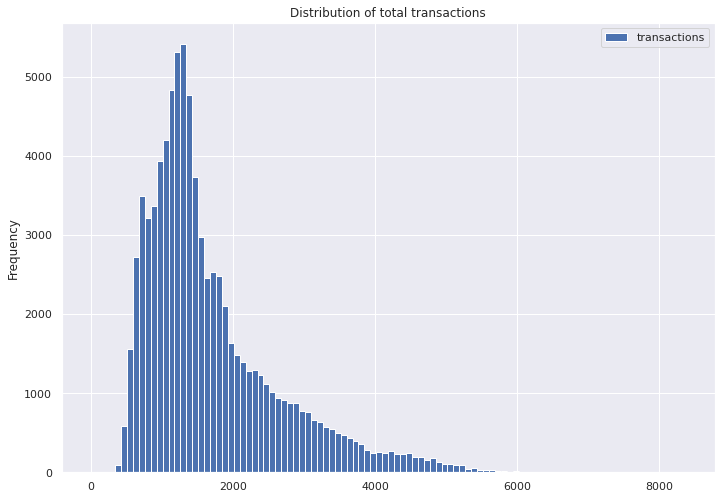

In [0]:
spark.sql('select transactions from transactions_data').toPandas().plot.hist(bins = 100)
plt.title('Distribution of total transactions')

This is a very informative plot as it tells us that the total number of transactions is approximately Poisson distributed. Perhaps the number of transactions for particular items are also Poisson distributed.

<h1> Oil Data </h1>

In [0]:
oil_df.printSchema()

root
 |-- date: string (nullable = true)
 |-- dcoilwtico: string (nullable = true)



In [0]:
oil_df.show()

+----------+----------+
|      date|dcoilwtico|
+----------+----------+
|2013-01-01|      null|
|2013-01-02|     93.14|
|2013-01-03|     92.97|
|2013-01-04|     93.12|
|2013-01-07|      93.2|
|2013-01-08|     93.21|
|2013-01-09|     93.08|
|2013-01-10|     93.81|
|2013-01-11|      93.6|
|2013-01-14|     94.27|
|2013-01-15|     93.26|
|2013-01-16|     94.28|
|2013-01-17|     95.49|
|2013-01-18|     95.61|
|2013-01-21|      null|
|2013-01-22|     96.09|
|2013-01-23|     95.06|
|2013-01-24|     95.35|
|2013-01-25|     95.15|
|2013-01-28|     95.95|
+----------+----------+
only showing top 20 rows



In [0]:
oil_df.dtypes

[('date', 'string'), ('dcoilwtico', 'string')]

In [0]:
oil_df = oil_df.withColumn('date', col('date').cast(DateType())).withColumn('dcoilwtico', col('dcoilwtico').cast(FloatType()))

In [0]:
oil_df.dtypes

[('date', 'date'), ('dcoilwtico', 'float')]

In [0]:
oil_df.createOrReplaceTempView('oil_data')
oil_df.cache

<bound method DataFrame.cache of DataFrame[date: date, dcoilwtico: float]>

In [0]:
oil_df = spark.sql('select date, dcoilwtico from oil_data').toPandas()

Text(0.5, 1.0, 'Plot of oil prices over time')

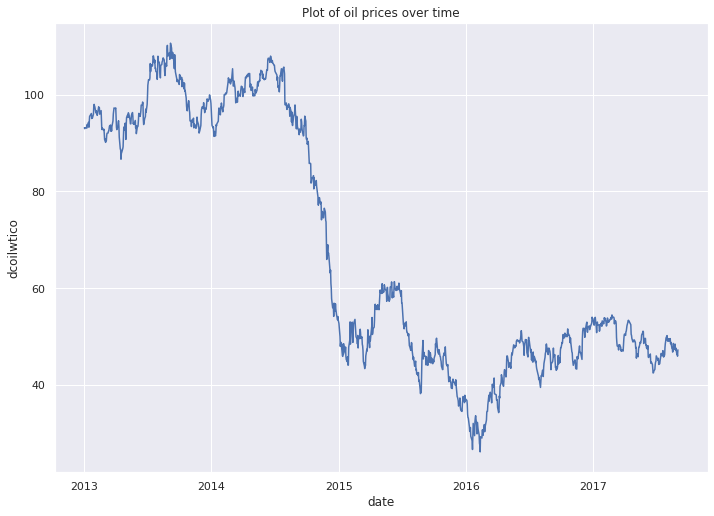

In [0]:
sns.lineplot(x=oil_df['date'], y=oil_df['dcoilwtico'])
plt.title('Plot of oil prices over time')

We see that oil prices suffered a collapse towards the end of 2014 and have not recovered. In fact despite some volatility, oil prices are at the same level as they were in the beginning of 2015. As a result of this we may see a significant shift in store sales around late 2014. Looking at the unit sales data, this is not readily apparent. Although sales do appear to drop off in the early part of 2015, in late 2014 they are rising. Also, to add oil price drop doesn't seems to have any impact on the sales, as it was seen from the sales plot, there was no relation between oil price dropping on the sales, so we can say that this feature or data is of no importance to us and will not be considered during modelling..

<h1> Holiday Data </h1>

In [5]:
holidays_events_df.printSchema()

root
 |-- date: string (nullable = true)
 |-- type: string (nullable = true)
 |-- locale: string (nullable = true)
 |-- locale_name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- transferred: string (nullable = true)



In [6]:
holidays_events_df.show()

+----------+-------+--------+-------------+--------------------+-----------+
|      date|   type|  locale|  locale_name|         description|transferred|
+----------+-------+--------+-------------+--------------------+-----------+
|2012-03-02|Holiday|   Local|        Manta|  Fundacion de Manta|      False|
|2012-04-01|Holiday|Regional|     Cotopaxi|Provincializacion...|      False|
|2012-04-12|Holiday|   Local|       Cuenca| Fundacion de Cuenca|      False|
|2012-04-14|Holiday|   Local|     Libertad|Cantonizacion de ...|      False|
|2012-04-21|Holiday|   Local|     Riobamba|Cantonizacion de ...|      False|
|2012-05-12|Holiday|   Local|         Puyo|Cantonizacion del...|      False|
|2012-06-23|Holiday|   Local|     Guaranda|Cantonizacion de ...|      False|
|2012-06-25|Holiday|Regional|     Imbabura|Provincializacion...|      False|
|2012-06-25|Holiday|   Local|    Latacunga|Cantonizacion de ...|      False|
|2012-06-25|Holiday|   Local|      Machala|Fundacion de Machala|      False|

In [0]:
holidays_events_df= holidays_events_df.withColumn('date', col('date').cast(DateType()))

In [8]:
holidays_events_df.dtypes

[('date', 'date'),
 ('type', 'string'),
 ('locale', 'string'),
 ('locale_name', 'string'),
 ('description', 'string'),
 ('transferred', 'string')]

In [9]:
holidays_events_df.createOrReplaceTempView('holidays_data')
holidays_events_df.cache

<bound method DataFrame.cache of DataFrame[date: date, type: string, locale: string, locale_name: string, description: string, transferred: string]>

**Plotting the count for all of the columns to see if we get any major info out of these**

In [0]:
def holiday_plot(x, y, txt):
  sns.set(rc={'figure.figsize':(12,10)})
  sns.barplot(x, y)
  plt.title(txt)
  plt.xticks(rotation=90)
  plt.show()

In [0]:
holidays_type_df = spark.sql('select type, COUNT(1) as count FROM holidays_data GROUP BY type ORDER BY count DESC').toPandas()
holidays_local_df = spark.sql('select locale, COUNT(1) as count FROM holidays_data GROUP BY locale ORDER BY count DESC').toPandas()
holidays_desc_df = spark.sql('select description, COUNT(1) as count FROM holidays_data GROUP BY description ORDER BY count DESC').toPandas()
holidays_transf_df = spark.sql('select transferred, COUNT(1) as count FROM holidays_data GROUP BY transferred ORDER BY count DESC').toPandas()
holidays_locnam_df = spark.sql('select locale_name, COUNT(1) as count FROM holidays_data GROUP BY locale_name ORDER BY count DESC').toPandas()

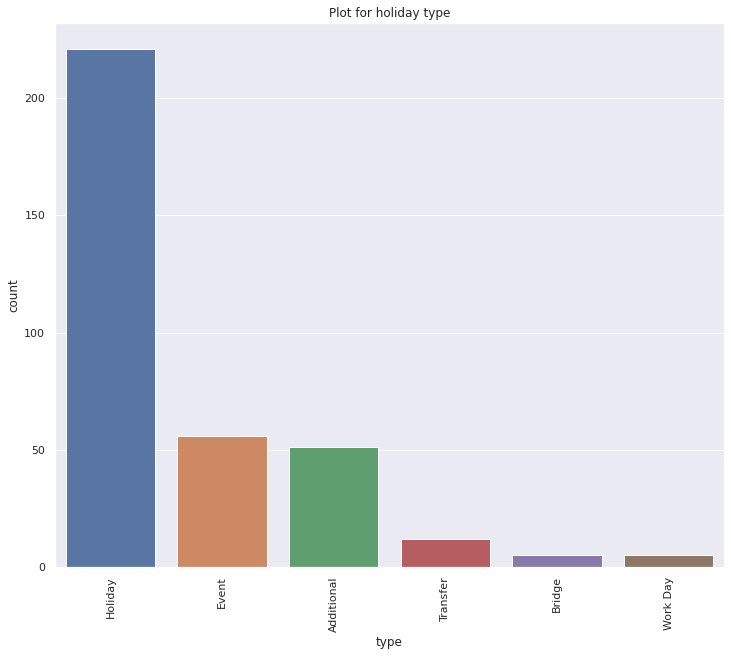

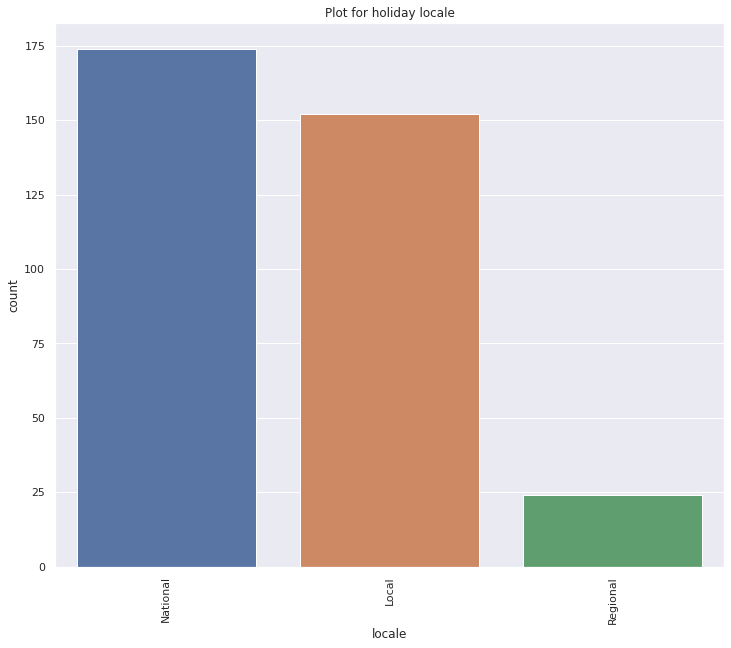

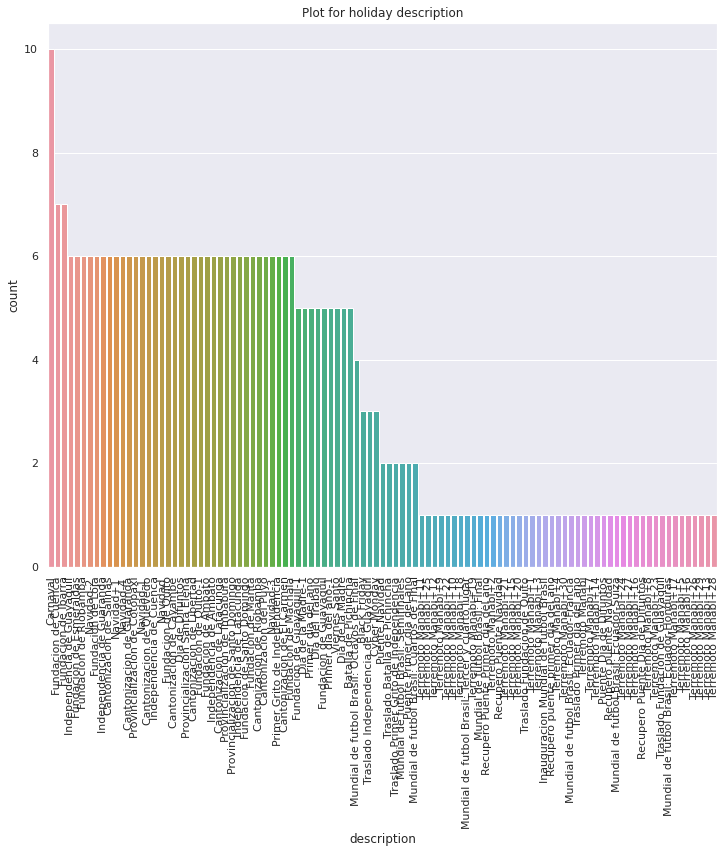

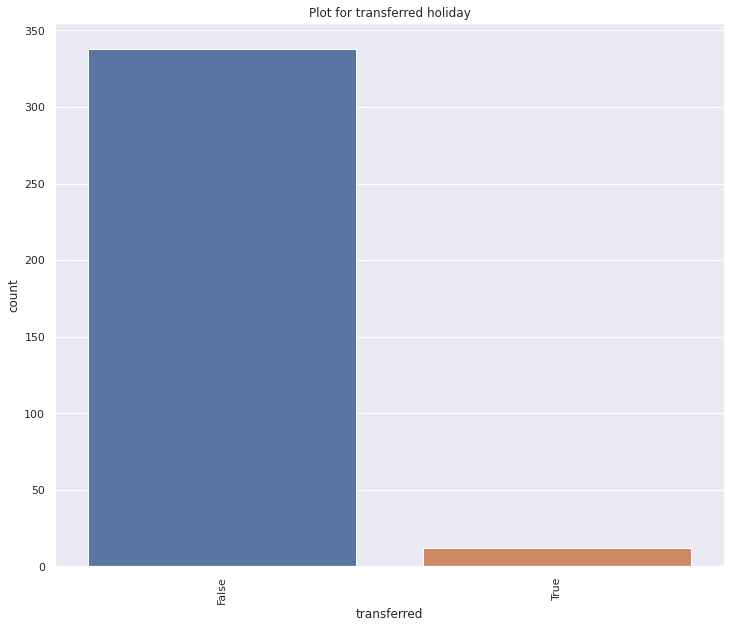

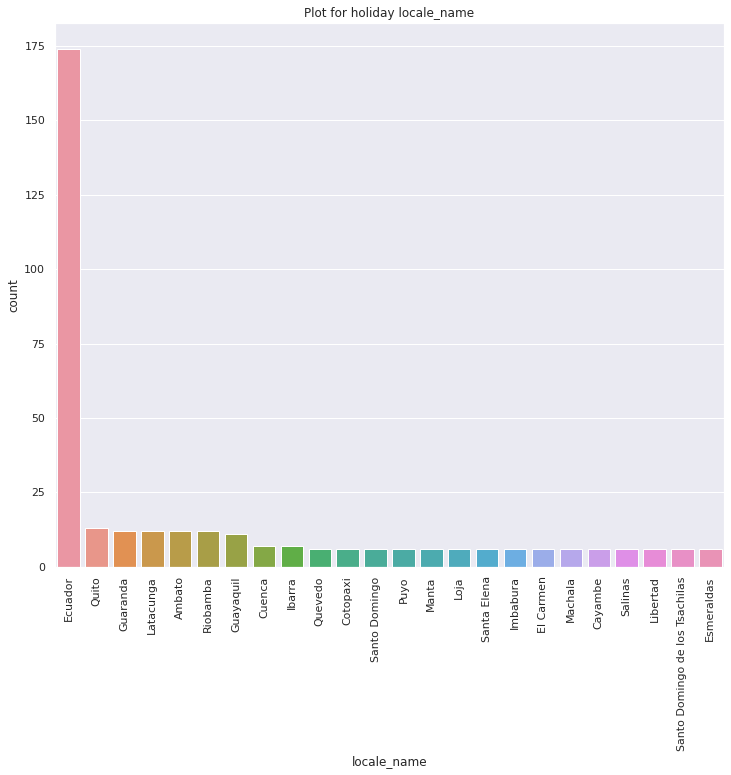

In [15]:
holiday_plot(holidays_type_df['type'], holidays_type_df['count'], 'Plot for holiday type')
holiday_plot(holidays_local_df['locale'], holidays_local_df['count'], 'Plot for holiday locale')
holiday_plot(holidays_desc_df['description'], holidays_desc_df['count'], 'Plot for holiday description')
holiday_plot(holidays_transf_df['transferred'], holidays_transf_df['count'], 'Plot for transferred holiday')
holiday_plot(holidays_locnam_df['locale_name'], holidays_locnam_df['count'], 'Plot for holiday locale_name')

Major Takeaway:
1. Most of the holiday types are national and locale.
2. Carnavals have the highest number of holidays
3. There are few transferred holidays.

**Let's dig more on this transferred holiday type**

In [0]:
spark.sql('select transferred, type, count(1) as count FROM holidays_data GROUP BY transferred, type ORDER BY count').show()

+-----------+----------+-----+
|transferred|      type|count|
+-----------+----------+-----+
|      False|    Bridge|    5|
|      False|  Work Day|    5|
|       True|   Holiday|   12|
|      False|  Transfer|   12|
|      False|Additional|   51|
|      False|     Event|   56|
|      False|   Holiday|  209|
+-----------+----------+-----+



This transferred features works a little different.It is not directly related to type == Transfer, but is assigned to the original holiday day prior to the transfer. This can be seen when we group by transferred and type. What this means, is that a transferred holiday shows up twice in this data. First on its original date, but with a transferred == TRUE flag. This means that on this day there was no holiday. It was a normal working day. Instead, the moved holiday has a type == Transfer and a transferred == FALSE on the new date. This is a non-working day now.

**Let us see the number of holidays on yearly basis**

In [0]:
holiday_count_yearly = spark.sql('SELECT EXTRACT(YEAR FROM date) as year, count(1) as count FROM holidays_data GROUP BY year ORDER BY year').toPandas()

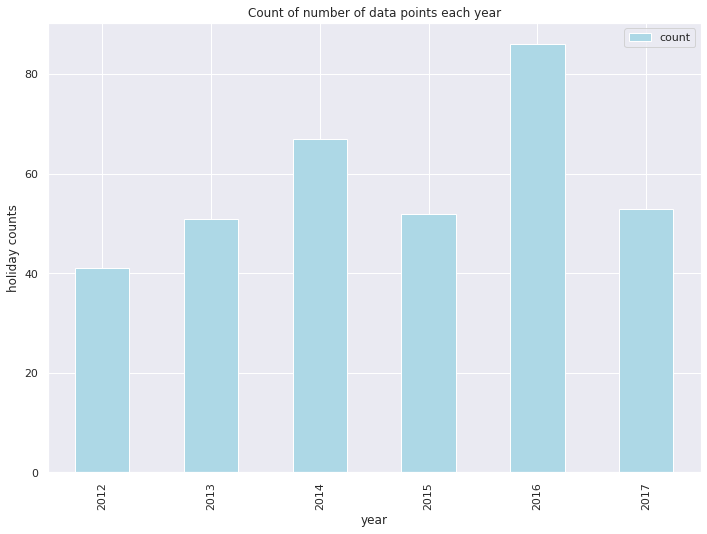

In [0]:
x_labels = holiday_count_yearly['year'].values
fig = holiday_count_yearly[['count']].plot(kind='bar', facecolor='lightblue')
fig.set_xticklabels(x_labels)
fig.set_title('Count of number of data points each year')
fig.set_xlabel('year')
fig.set_ylabel('holiday counts')
plt.show()


2014 and 2016 have a more number of holidays/events compared to other years, let's see why...

In [0]:
holiday_monthly_df = spark.sql('SELECT EXTRACT(MONTH FROM date) as month, EXTRACT(YEAR FROM date) as year, count(1) as count FROM holidays_data GROUP BY month, year ORDER BY year, month').toPandas()

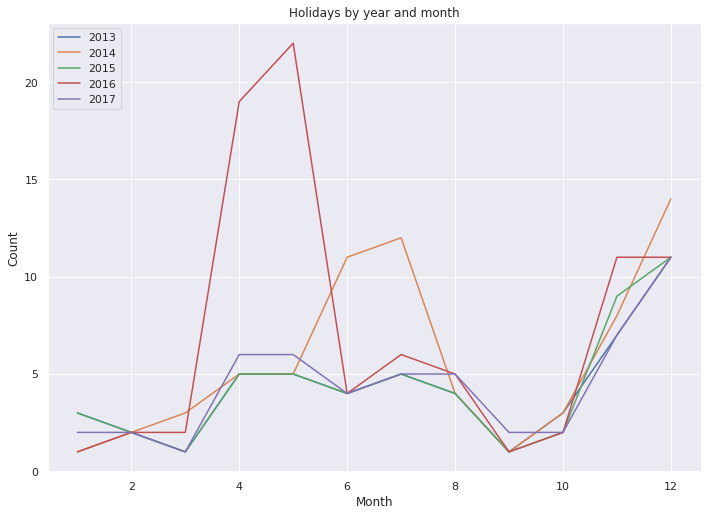

In [0]:
plt.plot(holiday_monthly_df[holiday_monthly_df['year'] == 2013]['month'].values, holiday_monthly_df[holiday_monthly_df['year'] == 2013]['count'].values)
plt.plot(holiday_monthly_df[holiday_monthly_df['year'] == 2014]['month'].values, holiday_monthly_df[holiday_monthly_df['year'] == 2014]['count'].values)
plt.plot(holiday_monthly_df[holiday_monthly_df['year'] == 2015]['month'].values, holiday_monthly_df[holiday_monthly_df['year'] == 2015]['count'].values)
plt.plot(holiday_monthly_df[holiday_monthly_df['year'] == 2016]['month'].values, holiday_monthly_df[holiday_monthly_df['year'] == 2016]['count'].values)
plt.plot(holiday_monthly_df[holiday_monthly_df['year'] == 2017]['month'].values, holiday_monthly_df[holiday_monthly_df['year'] == 2017]['count'].values)
plt.legend(['2013', '2014', '2015', '2016', '2017'], loc='upper left')
plt.title("Holidays by year and month")
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

From this we see that in 2016 for the month of 5 and in 2014 for month 7, there are high number of holidays as usual, and for 12th, it increases obviously because of Christmas and year end holidays. Let's see what we have  for the period of 201605 and 201407

In [0]:
spark.sql('SELECT date, type, description FROM holidays_data WHERE date BETWEEN \'2014-07-01\' AND \'2014-07-31\'').toPandas()

date        type                                      description
0   2014-07-01       Event       Mundial de futbol Brasil: Octavos de Final
1   2014-07-03     Holiday                       Cantonizacion de El Carmen
2   2014-07-03     Holiday                       Fundacion de Santo Domingo
3   2014-07-04       Event       Mundial de futbol Brasil: Cuartos de Final
4   2014-07-05       Event       Mundial de futbol Brasil: Cuartos de Final
5   2014-07-08       Event            Mundial de futbol Brasil: Semifinales
6   2014-07-09       Event            Mundial de futbol Brasil: Semifinales
7   2014-07-12       Event  Mundial de futbol Brasil: Tercer y cuarto lugar
8   2014-07-13       Event                  Mundial de futbol Brasil: Final
9   2014-07-23     Holiday                         Cantonizacion de Cayambe
10  2014-07-24  Additional                         Fundacion de Guayaquil-1
11  2014-07-25     Holiday                           Fundacion de Guayaquil

So, for 2014, it was the world cup, but then these are not the real holidays, these are the events.

In [0]:
spark.sql('SELECT date, type, description FROM holidays_data WHERE date BETWEEN \'2016-05-01\' AND \'2016-05-31\'').toPandas()

date        type                    description
0   2016-05-01     Holiday                Dia del Trabajo
1   2016-05-01       Event            Terremoto Manabi+15
2   2016-05-02       Event            Terremoto Manabi+16
3   2016-05-03       Event            Terremoto Manabi+17
4   2016-05-04       Event            Terremoto Manabi+18
5   2016-05-05       Event            Terremoto Manabi+19
6   2016-05-06       Event            Terremoto Manabi+20
7   2016-05-07  Additional              Dia de la Madre-1
8   2016-05-07       Event            Terremoto Manabi+21
9   2016-05-08       Event            Terremoto Manabi+22
10  2016-05-08       Event                Dia de la Madre
11  2016-05-09       Event            Terremoto Manabi+23
12  2016-05-10       Event            Terremoto Manabi+24
13  2016-05-11       Event            Terremoto Manabi+25
14  2016-05-12     Holiday         Cantonizacion del Puyo
15  2016-05-12       Event            Terremoto Manabi+26
16  2016-05-13       Event            Terremoto Manabi+27
17  2016-05-14       Event            Terremoto Manabi+28
18  2016-05-15       Event            Terremoto Manabi+29
19  2016-05-16       Event            Terremoto Manabi+30
20  2016-05-24     Holiday           Batalla de Pichincha
21  2016-05-27    Transfer  Traslado Batalla de Pichincha

This is when the earthquake occurred, sales may also increase at this time, as people tend to stock up more or give in charity to the person in need. This kind of an event is an external factor that shifts our time series from the actual behavior, during modelling we may need to check this.

**Finally let us see the mean sales per store bases on the holiday type**

In [0]:
sales_per_store_type = spark.sql('''SELECT date, type, sum(total_sales)/ count(store_nbr) as sales_per_store FROM
   (SELECT date, store_nbr, type, sum(unit_sales) as total_sales FROM 
     (SELECT a.date, a.store_nbr, a.unit_sales, b.type FROM (
      (SELECT date, store_nbr, unit_sales FROM data) a INNER JOIN 
        (SELECT date, type FROM holidays_data) b ON a.date = b.date)) GROUP BY date, store_nbr, type ORDER BY date) 
          GROUP BY date, type ORDER BY date''').toPandas()

Text(0.5, 1.0, 'Boxplot of mean sales_per_store by holiday type')

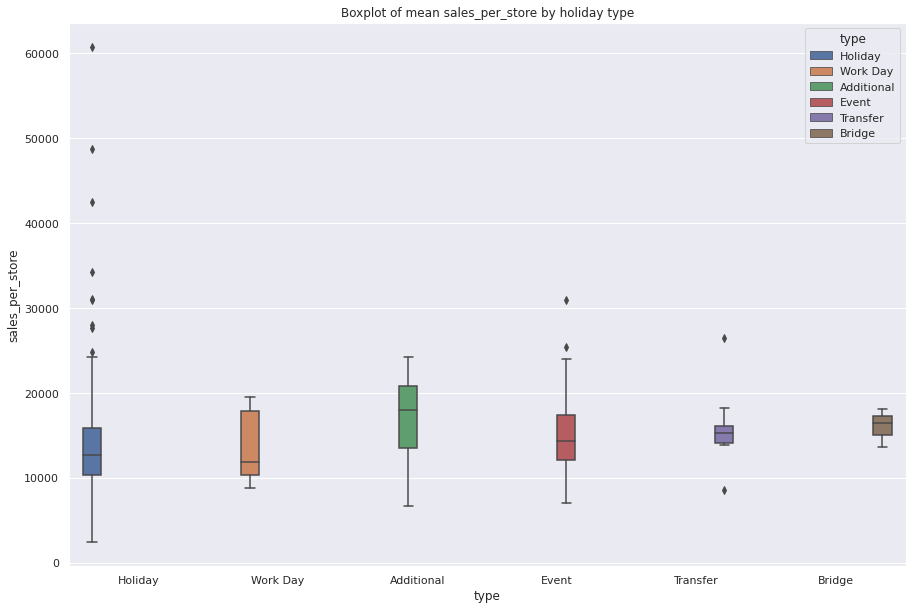

In [26]:
sns.set(rc={'figure.figsize':(15,10)})
sns.boxplot(x=sales_per_store_type['type'], y = sales_per_store_type['sales_per_store'], hue= sales_per_store_type['type'])
plt.title('Boxplot of mean sales_per_store by holiday type')

There is some indication of differences between groups if we talk about mean sales per store with type, some evident oulier points as seen from the box plots...

<h1> Conclusions from EDA</h1>

Major things that we saw after the analysis:

1. The missing values seen for the onpromotion field are for the initial days for which promotions were not tracked.
2. There is an upward trend in year by year sales, but this is because of the increase in number of items, if we look at the overall sales for an year, our signal seems close to stationary.
3. There are total 4036 items in the train data and overall item in universe is 4100, so there are items in test that are not part of train.
4. For item-store combination data is not available for all the days, or simply, not all items are sold at all stores everyday.
5. For new items, added recently, we may not have sufficient data points to train on.
6. Total number of stores are 54, out of which few stores geneartes maximum number of sales, Pichincha and Guayas have the maximum number of stores and sales as well.
7. Quito itself gives more than 70% of sales.
8. If we look at item level, we have total 33 familes of items, 337 classes and 24% of items are perishable.
9. Most of the items fall under common classes, such as Grocery, Beverages, Cleaning, Produce, Dairy. Also, classes are the subgroup of families.
10. If we try to plot signal for items, we see some items having seasonal effects and cyclic effects. Trend was not seen much, but the plotted sample was too small to make a conclusion on trend.
11. When looked at transaction level, it was found that there is a strong spike before Christmas, with corresponding drops when the stores are presumably closed during the holidays. Overall, the sales appear to be stable throughout this time range.
12. One important point that was seen was that the total number of transactions is approximately Poisson Distributed.
13. Oil price drop doesn't seems to have any impact on the sales, as it was seen from the sales plot, there was no relation between oil price dropping on the sales, so we can say that this feature or data is of no importance to us and will not be considered during modelling.
14. We saw high number of holiday events for 2014 and 2016, because of Football WorldCup and Earthquake.
15. When compared mean sales per store based on holiday type, some indication of differences between the groups was seen, also evident outlier points were seen.

<h1> Further Work </h1>

Now the major question is how to start with the work and what are the factors that needs to be considered during modelling phase.
We need to make sure what our goal is, we want to forecast the sales per item at store level. Also, we have some what 4036 time series clubbed together to work with, but this number will increase if we take every time series at item-store level.

One way to start is by generating results at chain level and then we can simply calculate factors for each store and multiply the chain level results with stores to give the final results.

Or, we can start by simply training the model at item-store level.It will be really important to see how to normalise the effect of number of stores on which the item is sell or simply saying we may need to to normalize the sales before feeding them to model, an example of this is that, let say an item is sold at 5 stores in some date and 10 stores in some other day, so instead of feeding the raw number, we may need to normalise the effect by getting sales at a chain store level by simply multiplying by the number of stores where it was sold.

Now, we can start our analysis by a simple univariate model, with normalised sales data being used to generate forecast.
But, we may need to move this further, for which we may need to create lot of new features. Some may be binary features, some may be features based on count, but we need to make sure we don't overfit in the whole process.
All, this is part of the experimentation that needs to be done, before we come with the final models and final results.......